In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier
from joblib import Parallel, delayed


In [2]:
def load_datasets_from_folder(folder_path):
    """Load all CSV datasets from a folder into a dictionary."""
    return {
        os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder_path, file))
        for file in os.listdir(folder_path) if file.endswith('.csv')
    }

# Specify folder path
folder_path = r"\\wsl.localhost\Ubuntu\home\kleinr1\RF-Overample\datasets"

# Load datasets
datasets = load_datasets_from_folder(folder_path)

# Output results
print(f"Total datasets loaded successfully: {len(datasets)}")
print("Successfully loaded datasets:")
for name, df in datasets.items():
    print(f" - {name} (Rows: {len(df)}, Columns: {len(df.columns)})")

Total datasets loaded successfully: 30
Successfully loaded datasets:
 - tic-tac-toe (Rows: 958, Columns: 10)
 - heart_disease (Rows: 303, Columns: 14)
 - lymphography (Rows: 148, Columns: 19)
 - sonar (Rows: 208, Columns: 61)
 - flare1 (Rows: 323, Columns: 11)
 - crx (Rows: 664, Columns: 15)
 - hepatitis (Rows: 138, Columns: 16)
 - mnist_test (Rows: 10000, Columns: 785)
 - wine (Rows: 178, Columns: 14)
 - balance_scale (Rows: 625, Columns: 5)
 - seeds (Rows: 199, Columns: 8)
 - optdigits (Rows: 3823, Columns: 65)
 - glass (Rows: 214, Columns: 10)
 - breast_cancer (Rows: 699, Columns: 10)
 - artificial_tree (Rows: 5000, Columns: 41)
 - chess (Rows: 3196, Columns: 37)
 - ecoli_5 (Rows: 327, Columns: 8)
 - audiology (Rows: 190, Columns: 68)
 - titanic (Rows: 712, Columns: 8)
 - iris (Rows: 150, Columns: 5)
 - ionosphere (Rows: 351, Columns: 35)
 - parkinsons (Rows: 195, Columns: 23)
 - zoo (Rows: 101, Columns: 18)
 - hill_valley (Rows: 606, Columns: 101)
 - segmentation (Rows: 211, Column

In [215]:
# Check Columns and Rows of Individual Datasets
print(datasets.get("titanic").head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [3]:
class DatasetPreprocessor:
    def __init__(self, dataset, target_column=None, test_size=0.3, random_state=42):
        self.dataset = dataset
        self.target_column = target_column if target_column else dataset.columns[0]
        self.test_size = test_size
        self.random_state = random_state
        self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None
        self._prepare_data()

    def _prepare_data(self):
        """Handles missing values, encodes categorical data, and splits dataset into train/test sets."""
        print(f"[DatasetPreprocessor] Processing dataset with target column: {self.target_column}")

        x = self.dataset.drop(columns=[self.target_column])
        y = self.dataset[self.target_column]

        # Identify numerical and categorical columns
        num_cols = x.select_dtypes(include=["number"]).columns
        cat_cols = x.select_dtypes(include=["object", "category"]).columns

        # Encode categorical features before handling missing values
        x = pd.get_dummies(x, drop_first=True)

        # Handle missing values AFTER encoding categorical variables
        x[num_cols] = x[num_cols].fillna(x[num_cols].median())  # Fill missing numerical values with median
        x = x.fillna(0)  # Fill missing categorical values with 0 (since one-hot encoding converted them)

        # Train-test split
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            x, y, test_size=self.test_size, random_state=self.random_state
        )

        print(f"[DatasetPreprocessor] Data split: Train ({len(self.x_train)}) / Test ({len(self.x_test)})")


In [4]:
# Extract Titanic dataset
titanic_data = datasets["titanic"]

# Initialize DatasetPreprocessor
preprocessor = DatasetPreprocessor(titanic_data, "Survived")

# Output the sizes of training and test sets
print(f"\n Training Set Size: {preprocessor.x_train.shape}")
print(f" Test Set Size: {preprocessor.x_test.shape}")


[DatasetPreprocessor] Processing dataset with target column: Survived
[DatasetPreprocessor] Data split: Train (498) / Test (214)

 Training Set Size: (498, 8)
 Test Set Size: (214, 8)


In [5]:
class ImbalanceHandler:
    def __init__(self, x_train, y_train, imbalance_ratio=0.2, batch_size=20, random_state=42):
        """
        Initializes the ImbalanceHandler class.

        Args:
            x_train (pd.DataFrame): Training feature set.
            y_train (pd.Series): Training labels.
            imbalance_ratio (float): Target imbalance ratio (default 0.2 for 20% minority).
            batch_size (int): The number of total samples per batch (default 20).
            random_state (int): Random state for reproducibility.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.imbalance_ratio = imbalance_ratio
        self.batch_size = batch_size
        self.random_state = random_state

    def introduce_imbalance(self):
        """Introduces class imbalance while ensuring divisibility by batch_size (default=20)."""
        print(f"[ImbalanceHandler] Applying imbalance ratio: {self.imbalance_ratio}")

        # Combine features & labels for easy manipulation
        train_df = pd.concat([self.x_train, self.y_train], axis=1)

        # Get class distributions
        class_counts = self.y_train.value_counts()
        print(f"[ImbalanceHandler] Original class distribution:\n{class_counts}")

        # Identify majority and minority class
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the classes
        minority_samples = train_df[train_df[self.y_train.name] == minority_class]
        majority_samples = train_df[train_df[self.y_train.name] == majority_class]

        # **Step 1: Adjust class sizes to be multiples of batch_size (default=20)**
        def adjust_class_size(df, class_name):
            """Ensures that the number of samples is a multiple of batch_size."""
            new_size = (len(df) // self.batch_size) * self.batch_size
            return resample(df, replace=False, n_samples=new_size, random_state=self.random_state)

        minority_samples = adjust_class_size(minority_samples, minority_class)
        majority_samples = adjust_class_size(majority_samples, majority_class)

        print(f"[ImbalanceHandler] Adjusted sizes - Minority: {len(minority_samples)}, Majority: {len(majority_samples)}")

        # **Step 2: Apply Imbalance Ratio in a Stepwise Manner**
        minority_per_batch = int(self.batch_size * self.imbalance_ratio)
        majority_per_batch = self.batch_size - minority_per_batch

        # Ensure we don't sample more than we have
        max_iterations = min(len(minority_samples) // minority_per_batch, len(majority_samples) // majority_per_batch)

        final_samples = []
        for _ in range(max_iterations):
            min_batch = resample(minority_samples, replace=False, n_samples=minority_per_batch, random_state=self.random_state)
            maj_batch = resample(majority_samples, replace=False, n_samples=majority_per_batch, random_state=self.random_state)
            final_samples.append(pd.concat([min_batch, maj_batch]))

        # **Step 3: Combine final dataset & Shuffle**
        imbalanced_train_df = pd.concat(final_samples).sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        print(f"[ImbalanceHandler] New class distribution:\n{imbalanced_train_df[self.y_train.name].value_counts()}")
        return imbalanced_train_df.drop(columns=[self.y_train.name]), imbalanced_train_df[self.y_train.name]

In [6]:
class ResamplingHandler:
    def __init__(self, x_train, y_train, random_state=42):
        self.x_train = x_train
        self.y_train = y_train
        self.random_state = random_state

    def apply_smote(self):
        smote = SMOTE(random_state=self.random_state)
        self.x_train, self.y_train = smote.fit_resample(self.x_train, self.y_train)

    def apply_adasyn(self):
        adasyn = ADASYN(random_state=self.random_state)
        self.x_train, self.y_train = adasyn.fit_resample(self.x_train, self.y_train)

    def apply_random_undersampling(self):
        rus = RandomUnderSampler(random_state=self.random_state)  # Reverted to automatic behavior
        self.x_train, self.y_train = rus.fit_resample(self.x_train, self.y_train)

In [13]:
class ModelTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, random_state=42):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.random_state = random_state
        self.model = None

        # Store a reset copy of the imbalanced dataset
        self.imbalanced_x_train = x_train.copy()
        self.imbalanced_y_train = y_train.copy()

    def reset_training_data(self):
        """Resets x_train and y_train back to the original imbalanced dataset before applying any method."""
        print("[ModelTrainer] Resetting to the original imbalanced dataset...")
        self.x_train = self.imbalanced_x_train.copy()
        self.y_train = self.imbalanced_y_train.copy()

    def train_and_evaluate(self, method="none", max_depth=None, n_estimators=20):
        """Trains a model with the selected method and evaluates its performance."""

        self.reset_training_data()

        print(f"[DEBUG] Class distribution before training (Method: {method}):")
        print(self.y_train.value_counts(normalize=True))  # Show class imbalance as a percentage


        # Initialize model based on method
        if method == "none":
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "class_weights":
            model = RandomForestClassifier(max_depth=max_depth, class_weight="balanced", random_state=self.random_state)
        elif method in ["smote", "adasyn", "random_undersampling"]:
            resampler = ResamplingHandler(self.x_train, self.y_train)
            if method == "smote":
                resampler.apply_smote()
            elif method == "adasyn":
                resampler.apply_adasyn()
            elif method == "random_undersampling":
                resampler.apply_random_undersampling()
            self.x_train, self.y_train = resampler.x_train, resampler.y_train
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "easy_ensemble":
            model = EasyEnsembleClassifier(n_estimators=n_estimators, random_state=self.random_state)
        else:
            raise ValueError("Invalid method specified.")

        # Train the model
        model.fit(self.x_train, self.y_train)
        self.model = model  

        predictions = model.predict(self.x_test)

        # Evaluate the model
        results = {
            "f1_score": f1_score(self.y_test, predictions, average="weighted"),
            "classification_report": classification_report(self.y_test, predictions, output_dict=True),
        }

        return results


In [8]:
class ExperimentRunner:
    """Runs multiple dataset configurations with different imbalance techniques and models."""
    
    def __init__(self, target_column=None, n_jobs=-1):
        """
        Initializes the experiment runner.
        
        Args:
            target_column (str or None): If None, the first column of the dataset will be used as the target.
            n_jobs (int): Number of parallel jobs (-1 means use all available cores).
        """
        self.target_column = target_column  # Target column can be specified or set dynamically per dataset
        self.n_jobs = n_jobs  

    def run_multiple_configs(self, datasets, methods, imbalance_ratios):
        """ Runs experiments with different datasets, methods, and imbalance ratios in parallel."""
        
        #  Run configurations in parallel using joblib
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._run_single_config)(name, dataset, method, ratio)
            for name, dataset in datasets.items()
            for method in methods
            for ratio in imbalance_ratios
        )
        
        print(f"\n Completed processing {len(results)} configurations.")
        return results

    def _run_single_config(self, dataset_name, dataset, method, imbalance_ratio):
        """Processes and trains a single dataset with a given method & imbalance ratio."""
        try:
            target_column = self.target_column if self.target_column else dataset.columns[0]

            preprocessor = DatasetPreprocessor(dataset, target_column=target_column)
            x_train, x_test, y_train, y_test = preprocessor.x_train, preprocessor.x_test, preprocessor.y_train, preprocessor.y_test

            imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio)
            x_train, y_train = imbalance_handler.introduce_imbalance()

            trainer = ModelTrainer(x_train, y_train, x_test, y_test)
            result = trainer.train_and_evaluate(method=method)

            report_str = classification_report(y_test, trainer.model.predict(x_test))

            return {
                "Dataset": dataset_name,
                "Method": method,
                "Imbalance Ratio": imbalance_ratio,
                "Weighted F1 Score": round(result["f1_score"], 4),
                "Classification Report": report_str  
            }
        
        except Exception as e:
            print(f"[ERROR] Experiment Failed for {dataset_name} | Method: {method} | Ratio: {imbalance_ratio}")
            print(str(e))
            return {
                "Dataset": dataset_name,
                "Method": method,
                "Imbalance Ratio": imbalance_ratio,
                "Error": str(e)
            }


In [9]:
# Step 1: Extract Titanic dataset
titanic_data = datasets["titanic"]

# Step 2: Define methods and imbalance ratios
methods = ["none", "smote", "class_weights", "random_undersampling", "adasyn", "easy_ensemble"]
imbalance_ratios = [0.2, 0.3, 0.4]

# Step 3: Initialize ExperimentRunner (Ensure target_column defaults correctly)
experiment_runner = ExperimentRunner(target_column=None, n_jobs=-1)

# Step 4: Run experiments
results = experiment_runner.run_multiple_configs(
    datasets=datasets, 
    methods=methods, 
    imbalance_ratios=imbalance_ratios
)


KeyboardInterrupt: 

In [20]:
# Step 1: Load Titanic dataset
titanic_data = datasets["titanic"]

# Step 2: Determine the target column (defaults to the first column)
target_column = titanic_data.columns[0]
print(f"[DEBUG] Using target column: {target_column}")

# Step 3: Preprocess the dataset
preprocessor = DatasetPreprocessor(titanic_data, target_column=target_column)
x_train, x_test, y_train, y_test = preprocessor.x_train, preprocessor.x_test, preprocessor.y_train, preprocessor.y_test

# Step 4: Specify model type (e.g., "none", "smote", "random_undersampling", "adasyn")
selected_model = "smote"  # Change this to "none", "random_undersampling", etc.

imbalance_ratio = 0.2  # Adjust to set desired imbalance
imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio=imbalance_ratio)
x_train, y_train = imbalance_handler.introduce_imbalance()

# Step 5: Apply class imbalance handling based on selected model
if selected_model == "none":
    print(f"[DEBUG] No resampling applied. Using natural class imbalance.")
elif selected_model in ["smote", "adasyn", "random_undersampling"]:
    resampler = ResamplingHandler(x_train, y_train)
    
    if selected_model == "smote":
        resampler.apply_smote()
    elif selected_model == "adasyn":
        resampler.apply_adasyn()
    elif selected_model == "random_undersampling":
        resampler.apply_random_undersampling()
    
    x_train, y_train = resampler.x_train, resampler.y_train
    print(f"[DEBUG] Applied {selected_model} resampling.")

# Step 6: Verify class distribution AFTER applying the imbalance method
print(f"[DEBUG] Class distribution after applying {selected_model}:")
print(y_train.value_counts(normalize=True))  # ✅ Should reflect the applied method

# Step 7: Train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# Step 8: Make predictions
predictions = model.predict(x_test)

# Step 9: Evaluate the model
f1 = f1_score(y_test, predictions, average="weighted")
report = classification_report(y_test, predictions)

# Step 10: Display results
print(f"\n[RESULTS] Weighted F1 Score: {f1:.4f}")
print("[RESULTS] Classification Report:")
print(report)

[DEBUG] Using target column: Survived
[DatasetPreprocessor] Processing dataset with target column: Survived
[DatasetPreprocessor] Data split: Train (498) / Test (214)
[ImbalanceHandler] Applying imbalance ratio: 0.2
[ImbalanceHandler] Original class distribution:
Survived
0    302
1    196
Name: count, dtype: int64
[ImbalanceHandler] Adjusted sizes - Minority: 180, Majority: 300
[ImbalanceHandler] New class distribution:
Survived
0    288
1     72
Name: count, dtype: int64
[DEBUG] Applied smote resampling.
[DEBUG] Class distribution after applying smote:
Survived
0    0.5
1    0.5
Name: proportion, dtype: float64

[RESULTS] Weighted F1 Score: 0.5285
[RESULTS] Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.92      0.72       122
           1       0.62      0.17      0.27        92

    accuracy                           0.60       214
   macro avg       0.61      0.55      0.50       214
weighted avg       0.60      0.60    

In [28]:
results

[{'Dataset': 'tic-tac-toe',
  'Method': 'none',
  'Imbalance Ratio': 0.2,
  'Weighted F1 Score': 0.6061,
  'Classification Report': '              precision    recall  f1-score   support\n\n    negative       0.40      0.31      0.35        95\n    positive       0.69      0.78      0.73       193\n\n    accuracy                           0.62       288\n   macro avg       0.55      0.54      0.54       288\nweighted avg       0.60      0.62      0.61       288\n'},
 {'Dataset': 'tic-tac-toe',
  'Method': 'none',
  'Imbalance Ratio': 0.3,
  'Weighted F1 Score': 0.6376,
  'Classification Report': '              precision    recall  f1-score   support\n\n    negative       0.45      0.52      0.48        95\n    positive       0.74      0.69      0.72       193\n\n    accuracy                           0.63       288\n   macro avg       0.60      0.60      0.60       288\nweighted avg       0.65      0.63      0.64       288\n'},
 {'Dataset': 'tic-tac-toe',
  'Method': 'none',
  'Imbalan

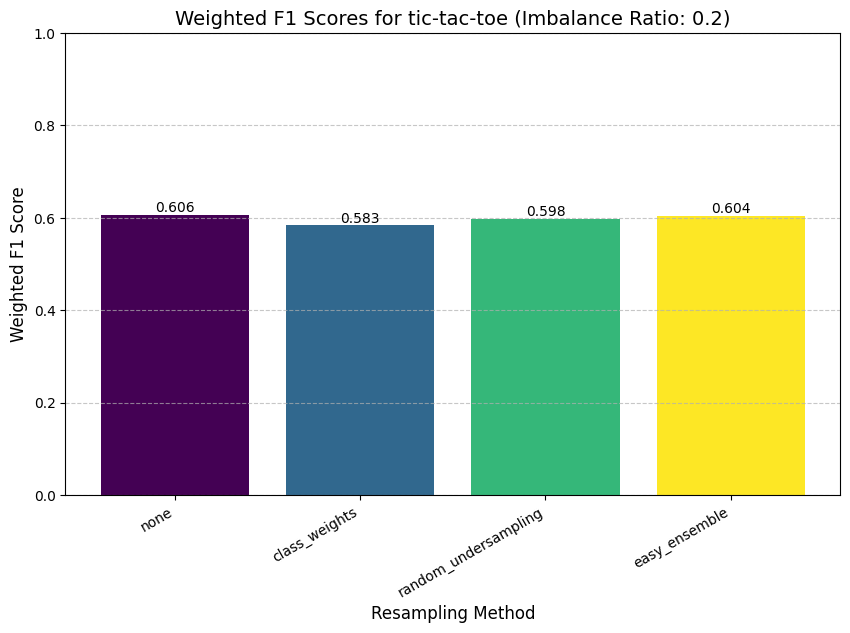

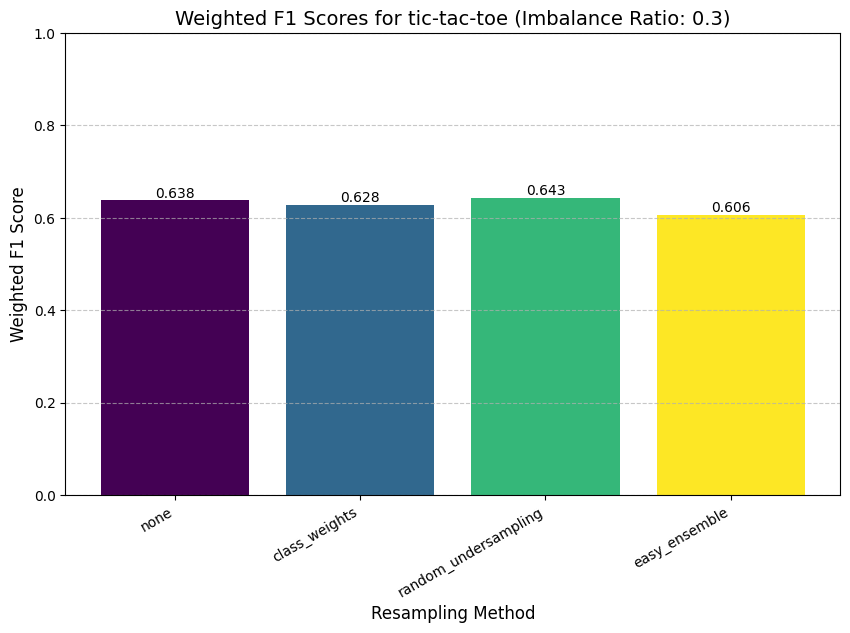

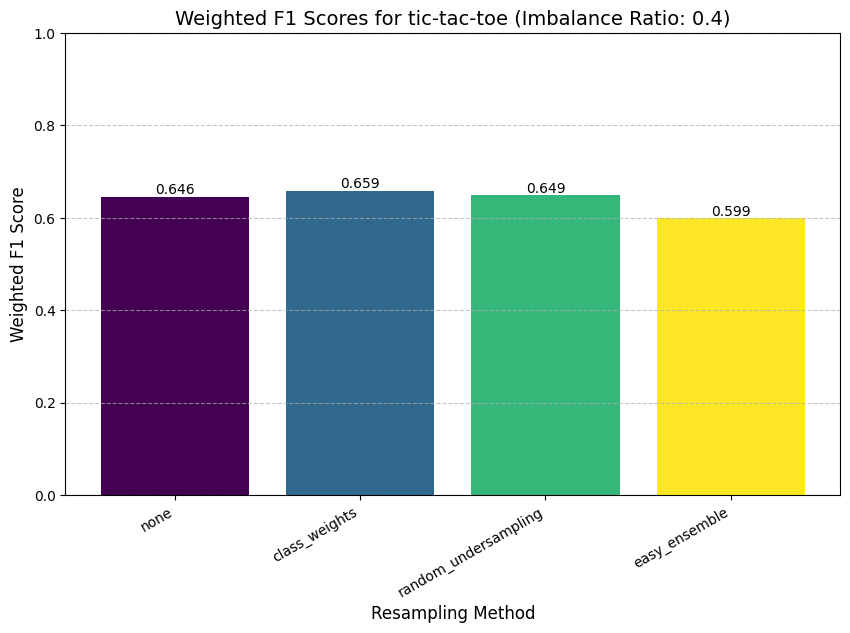

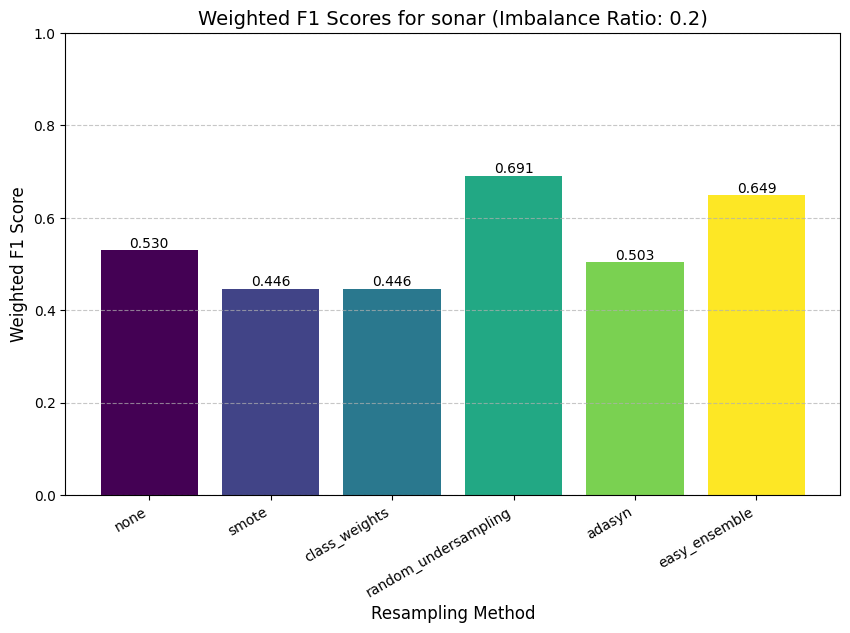

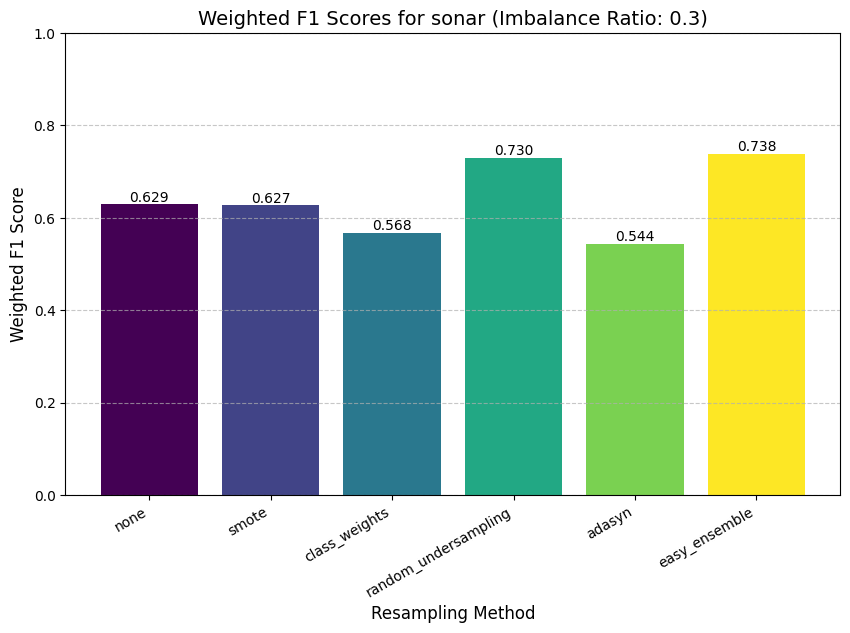

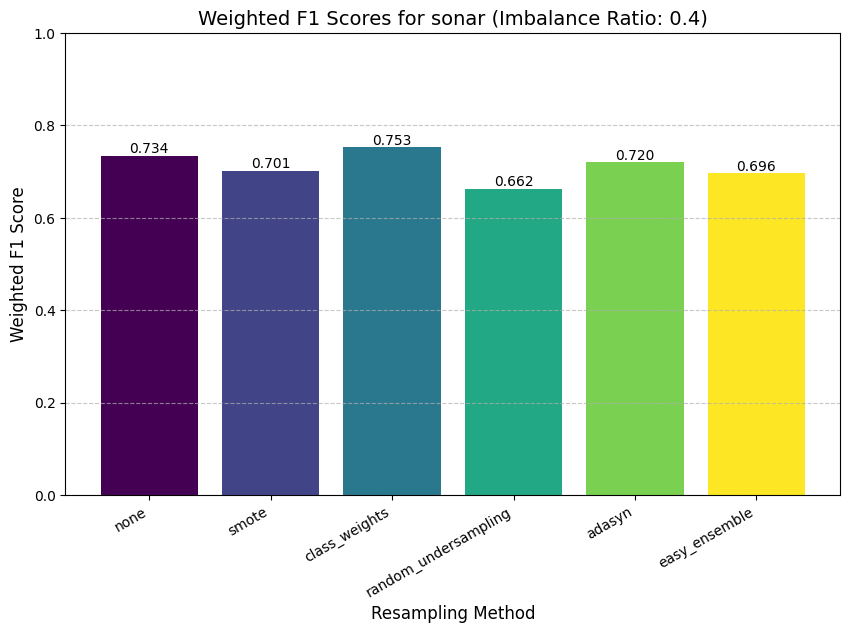

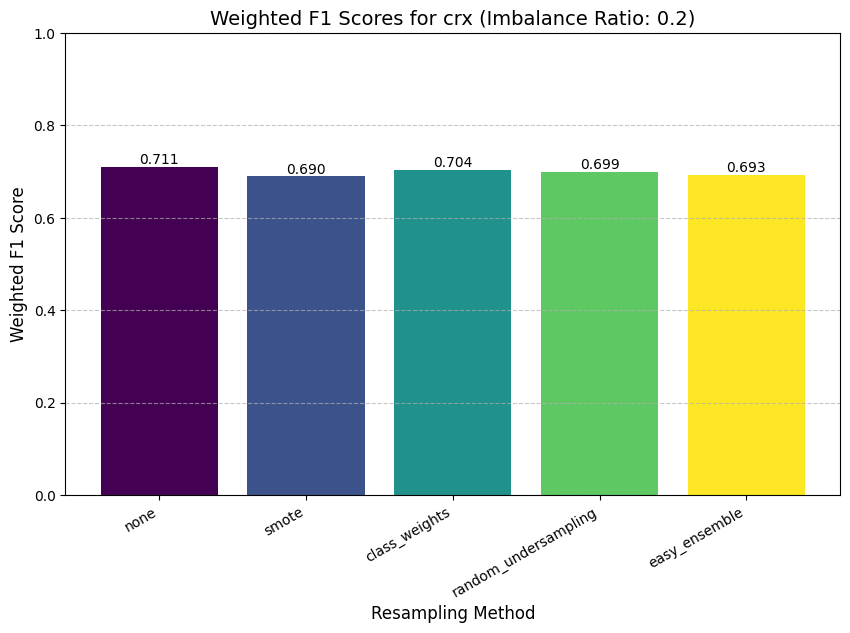

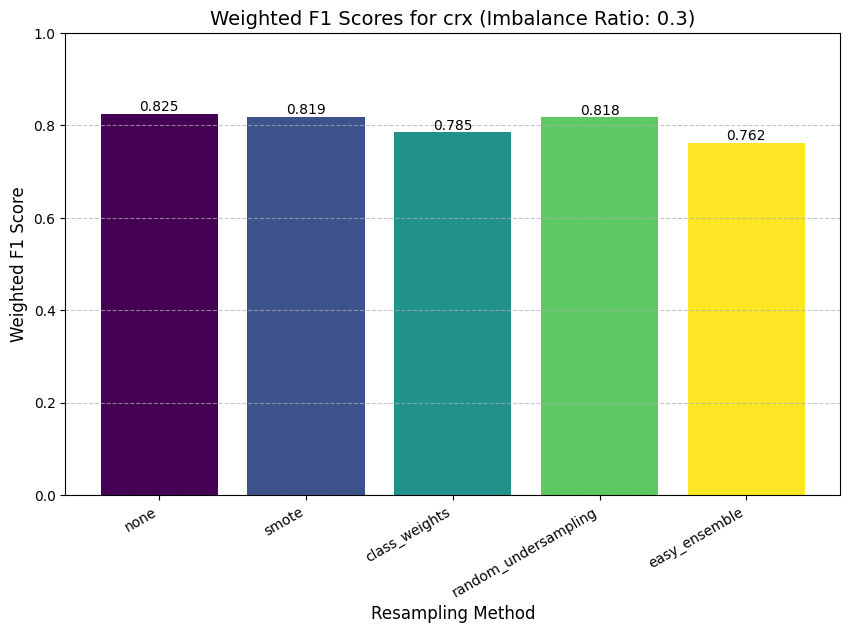

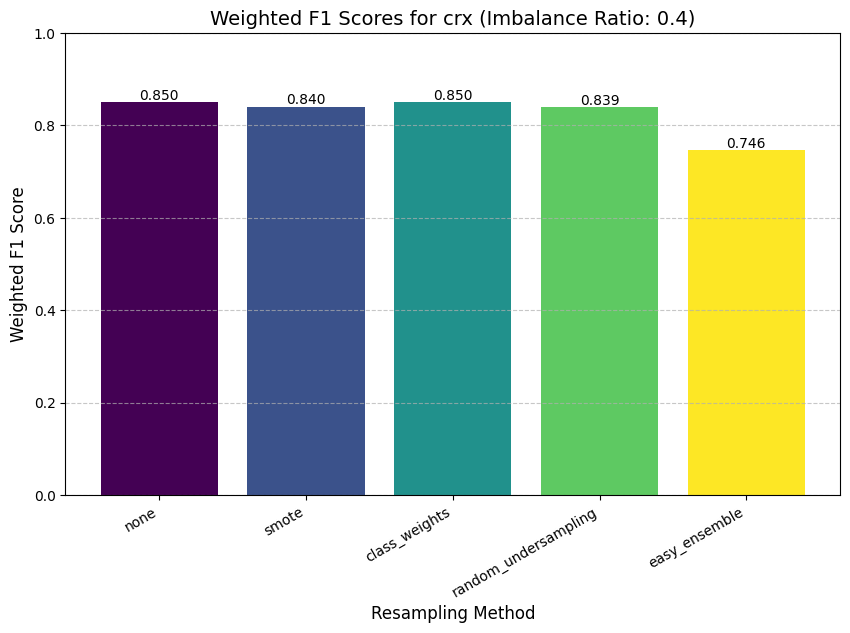

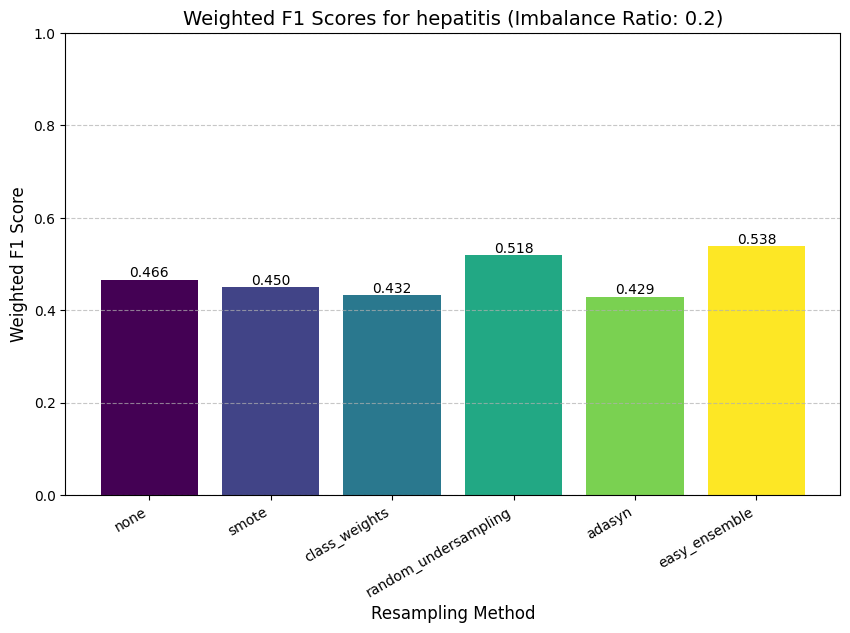

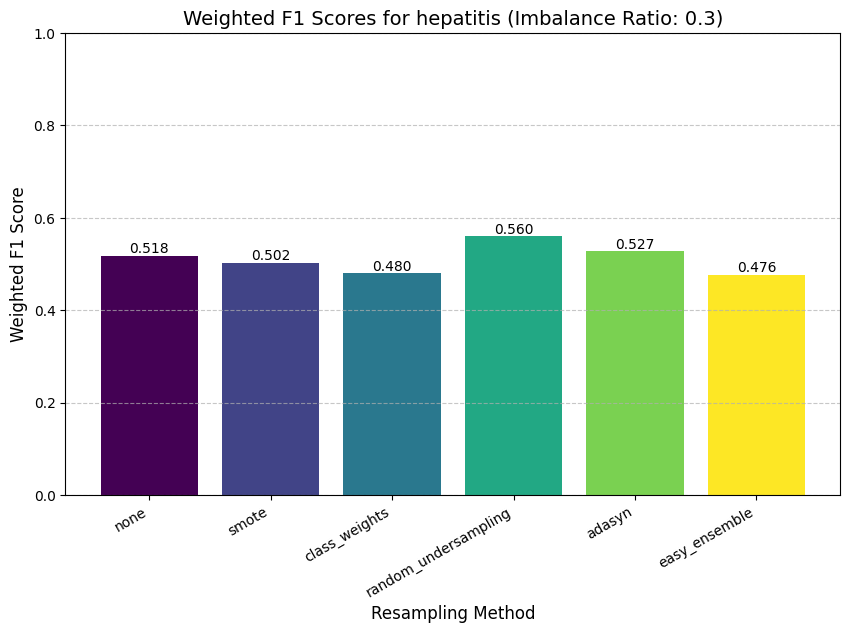

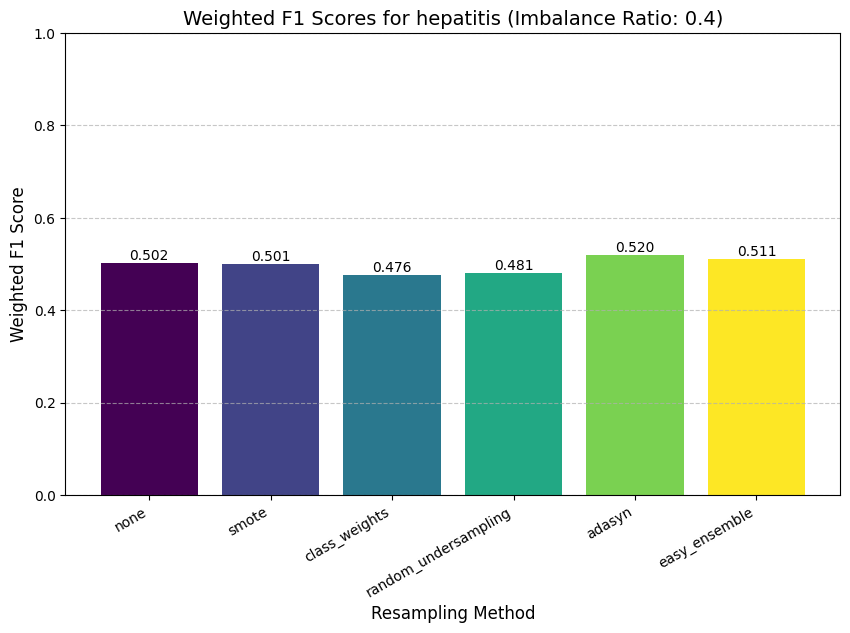

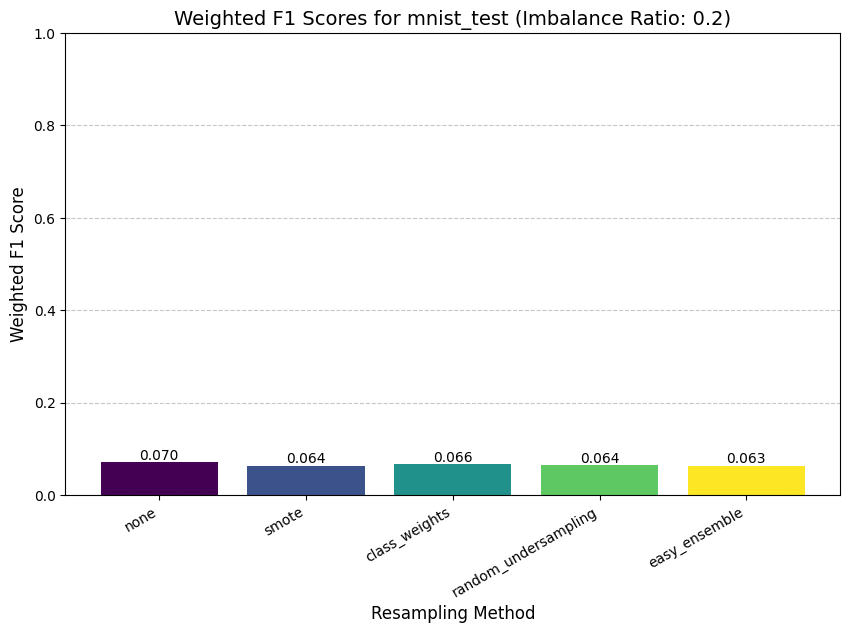

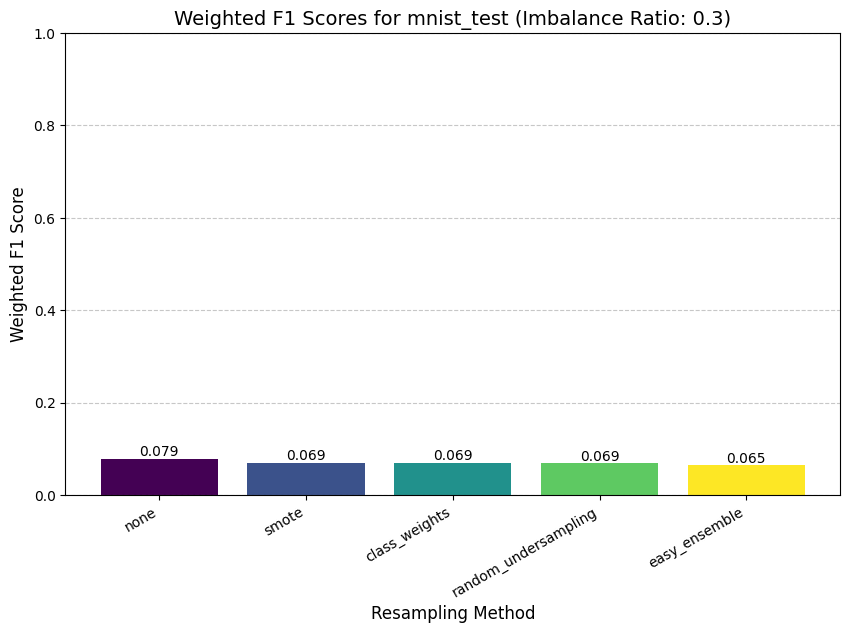

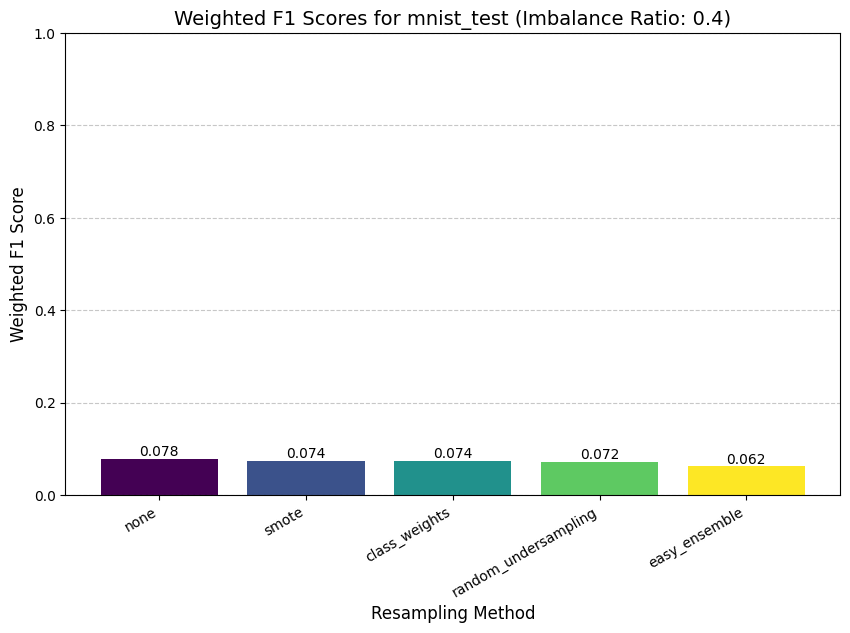

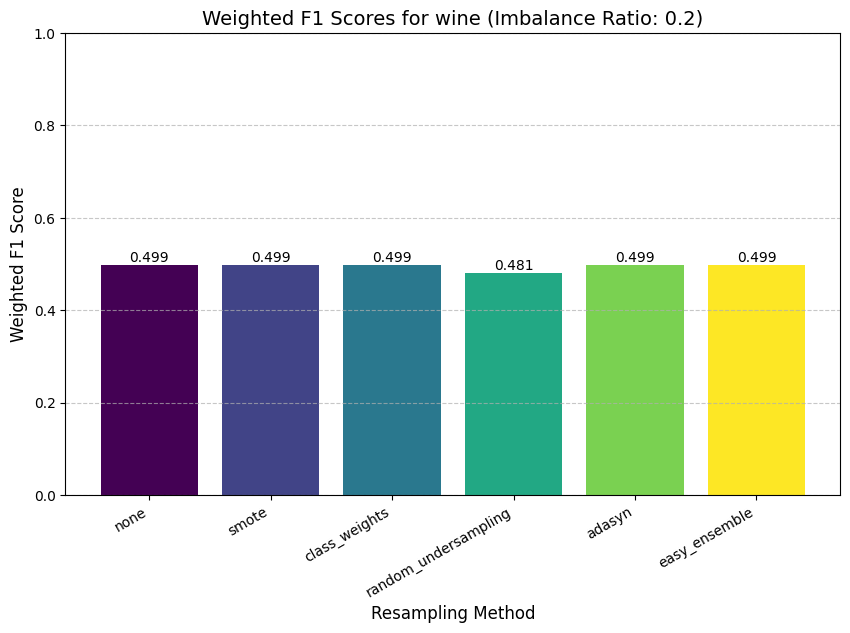

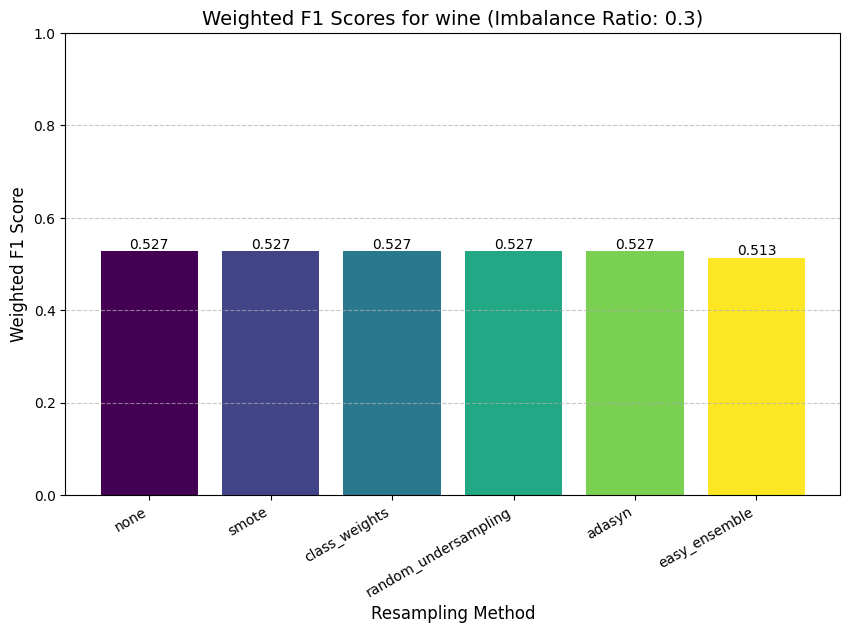

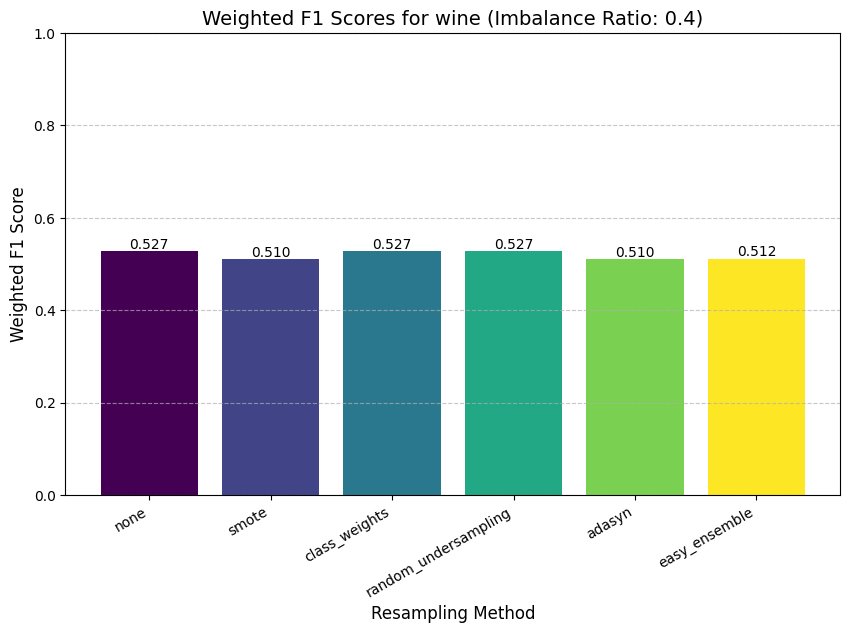

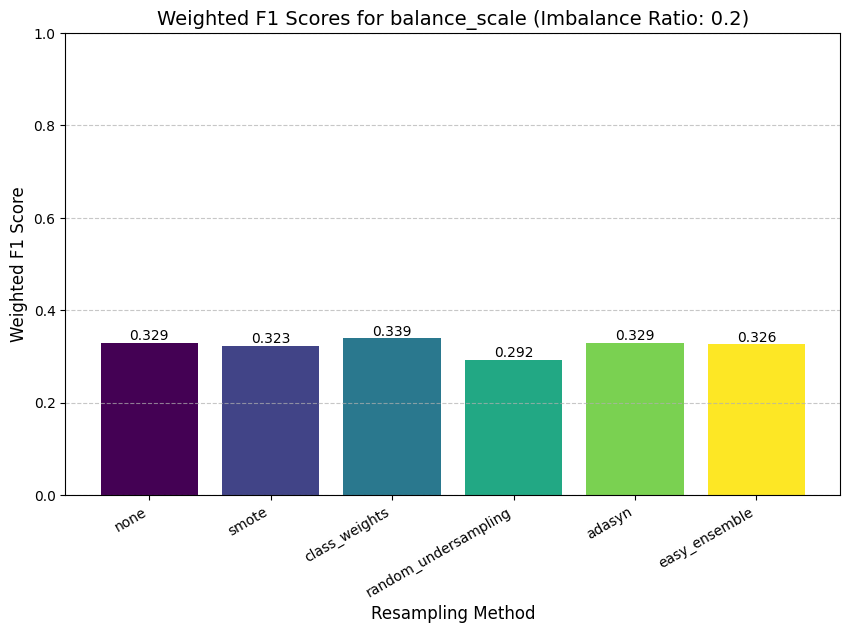

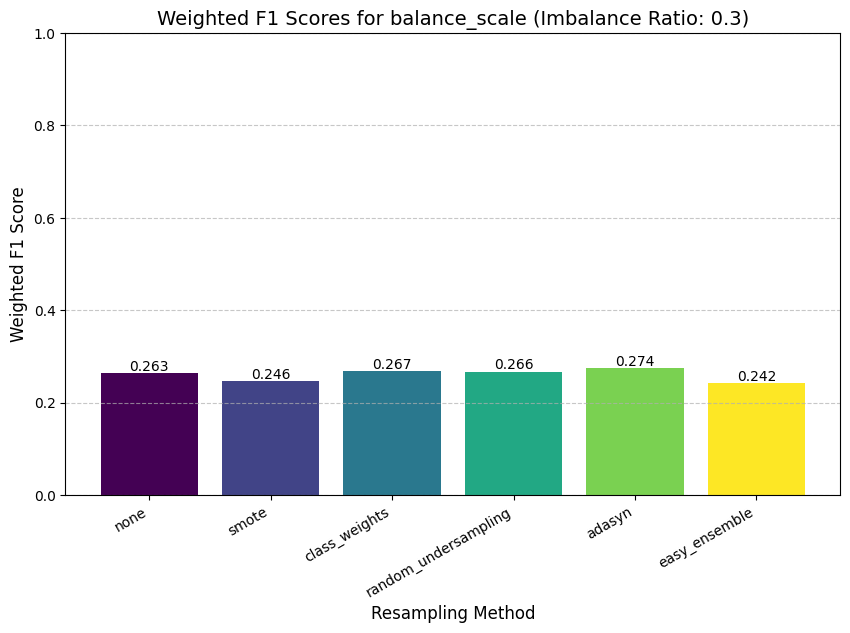

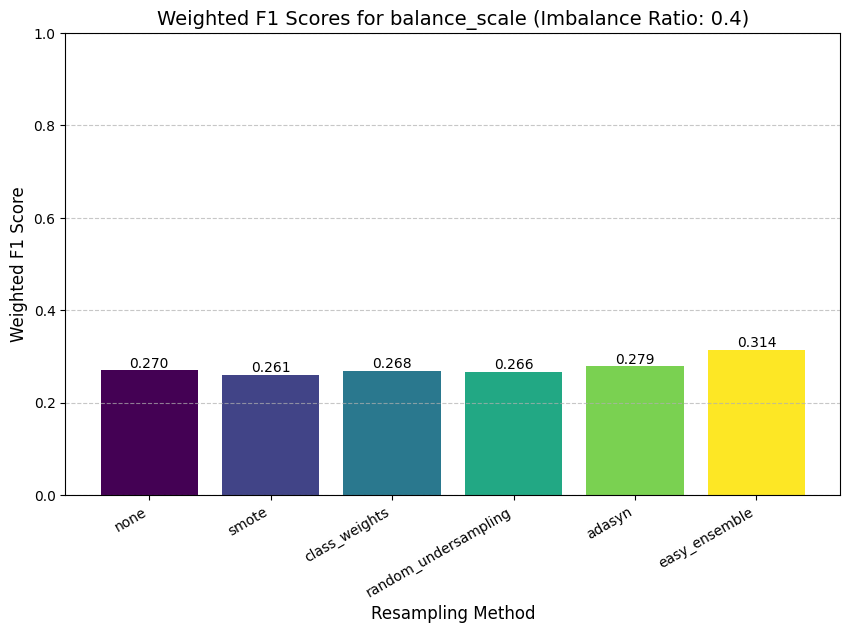

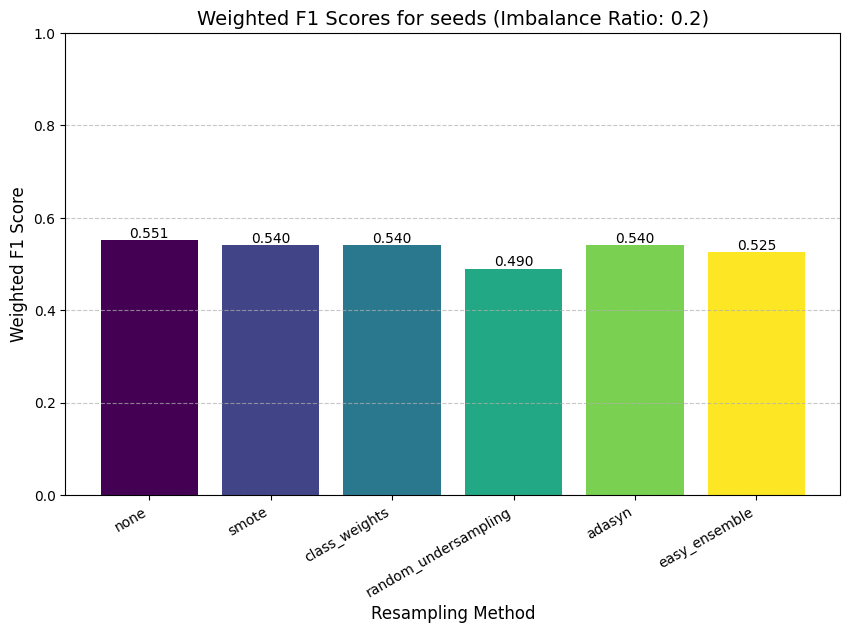

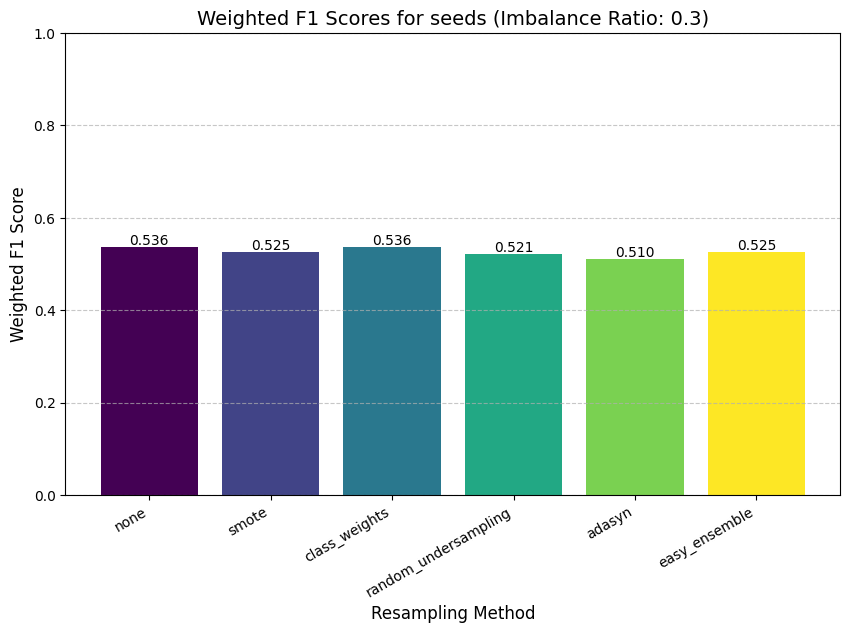

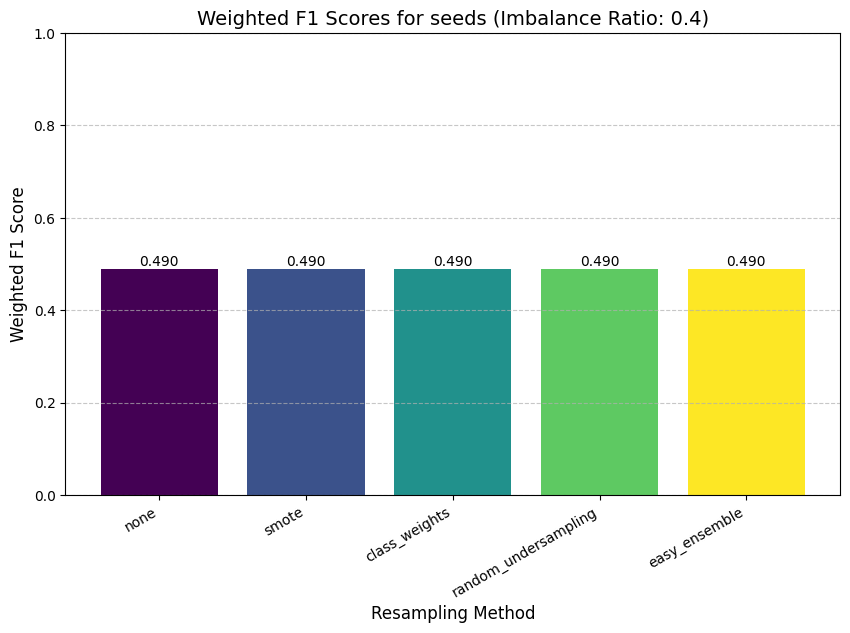

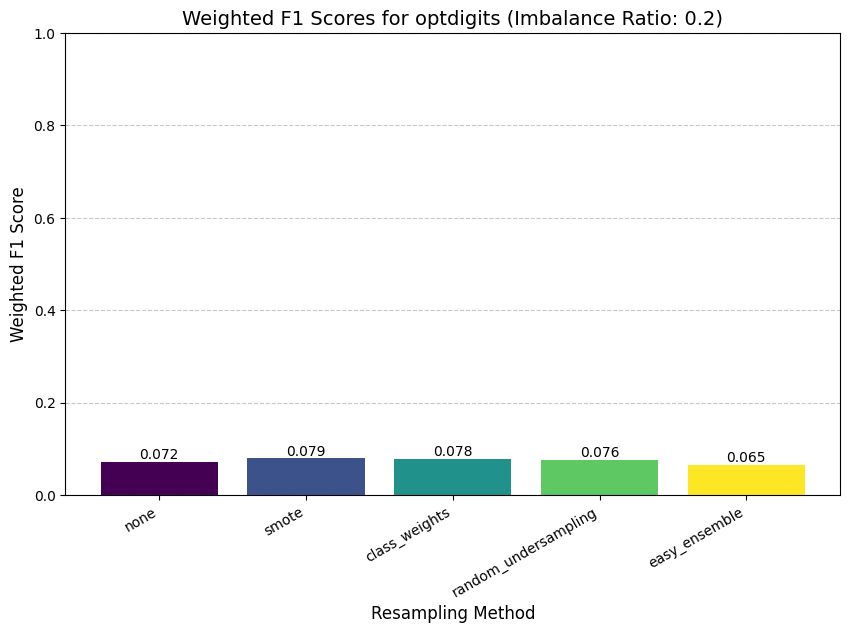

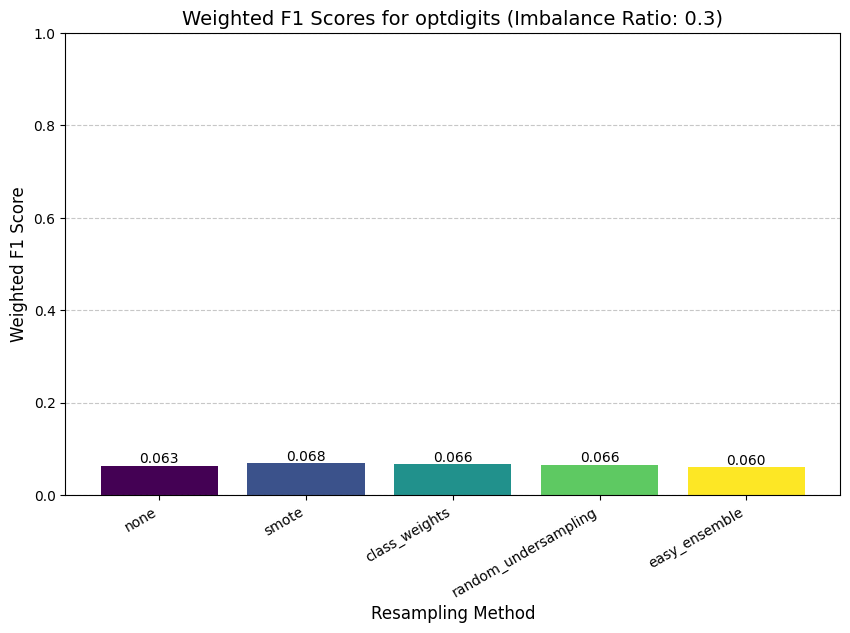

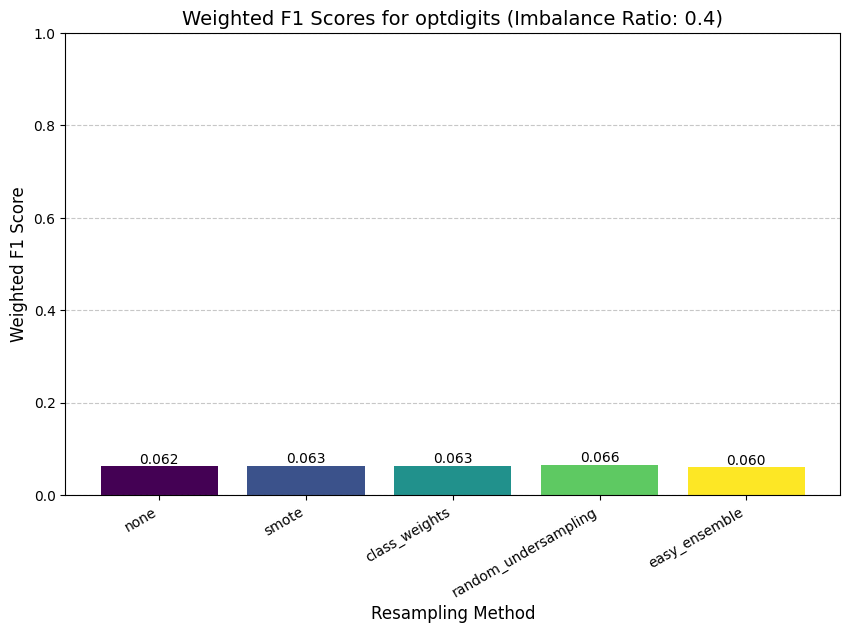

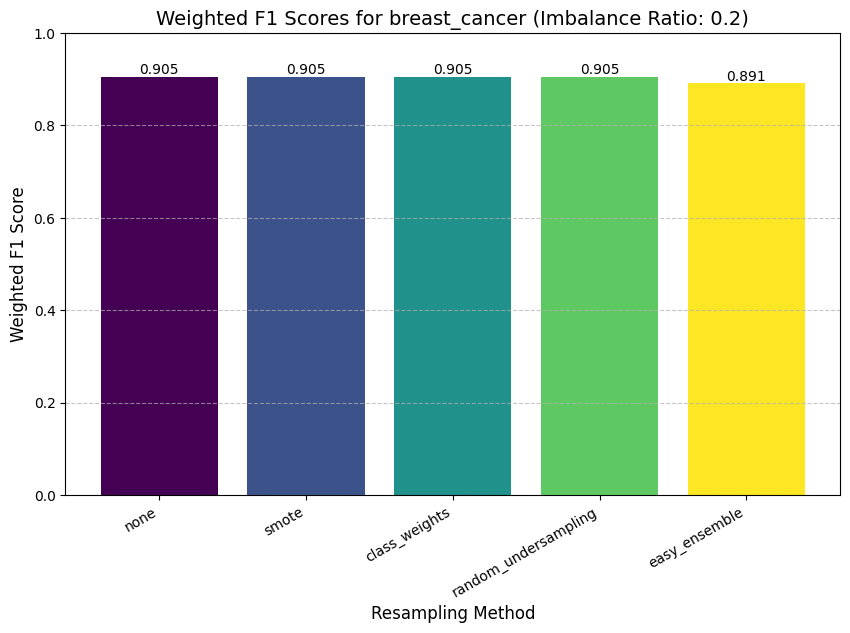

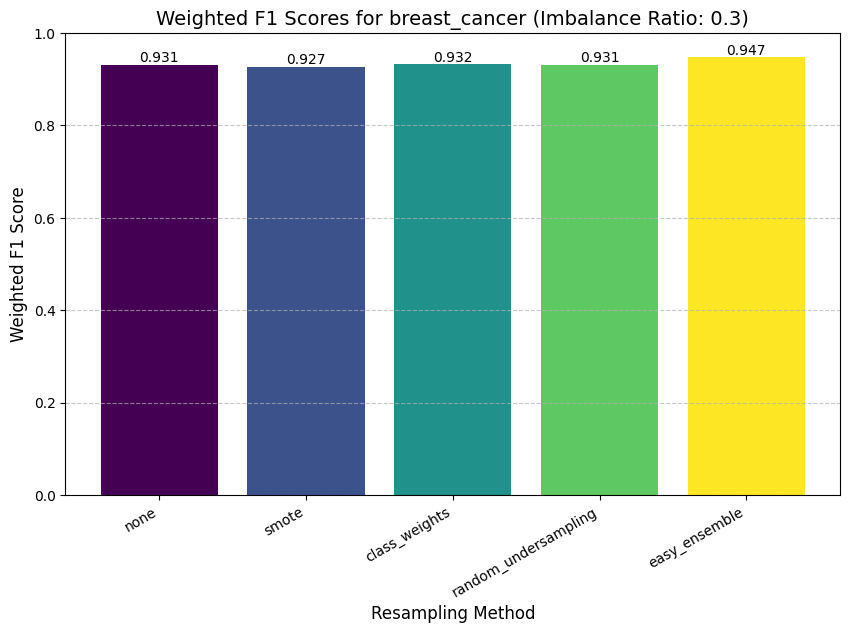

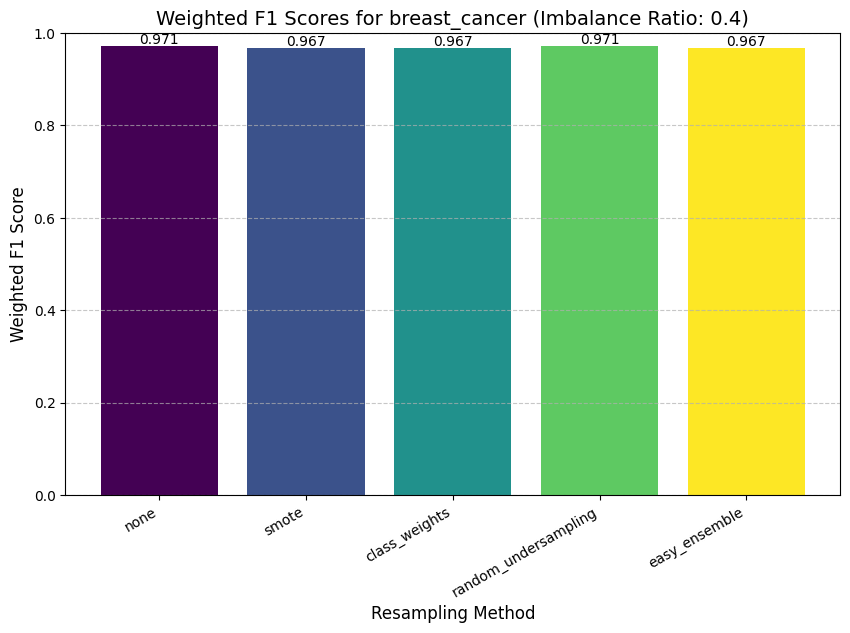

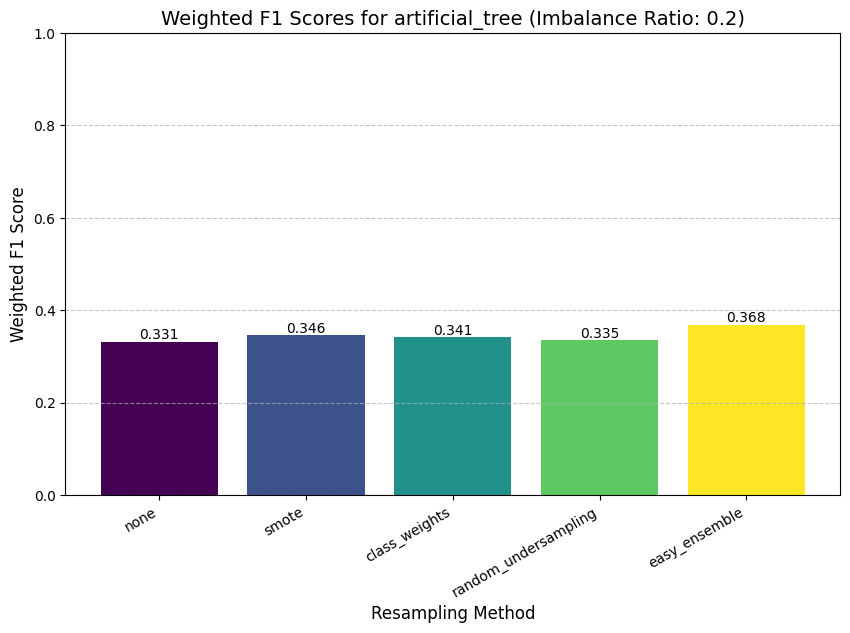

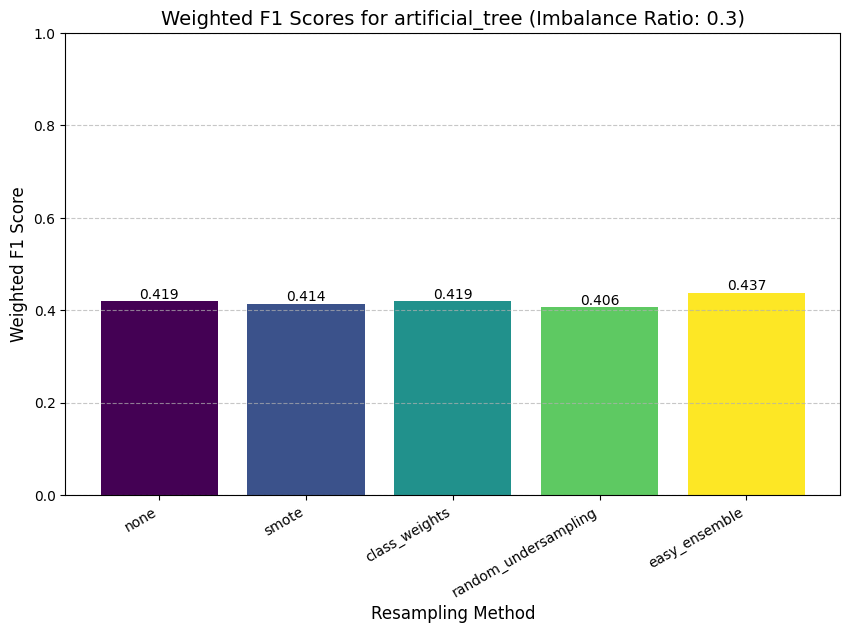

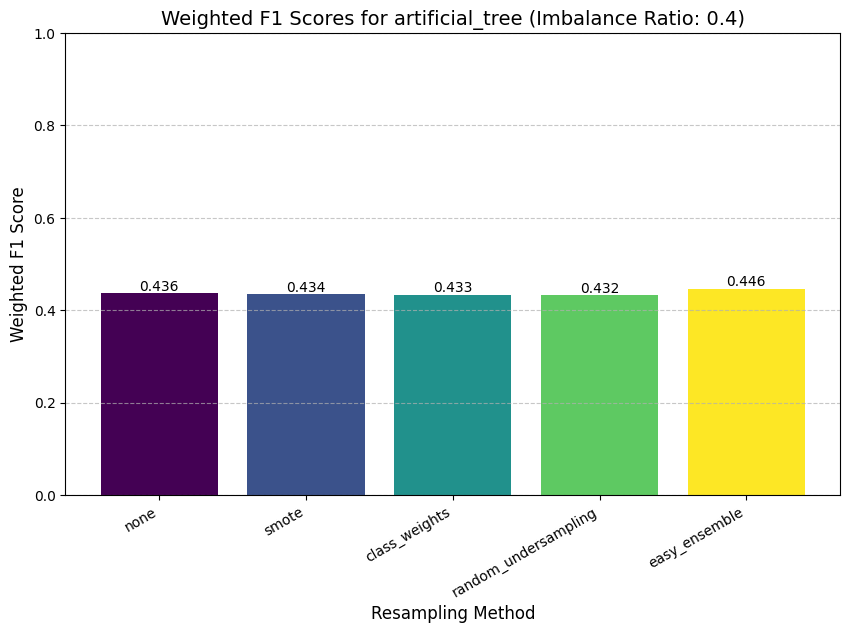

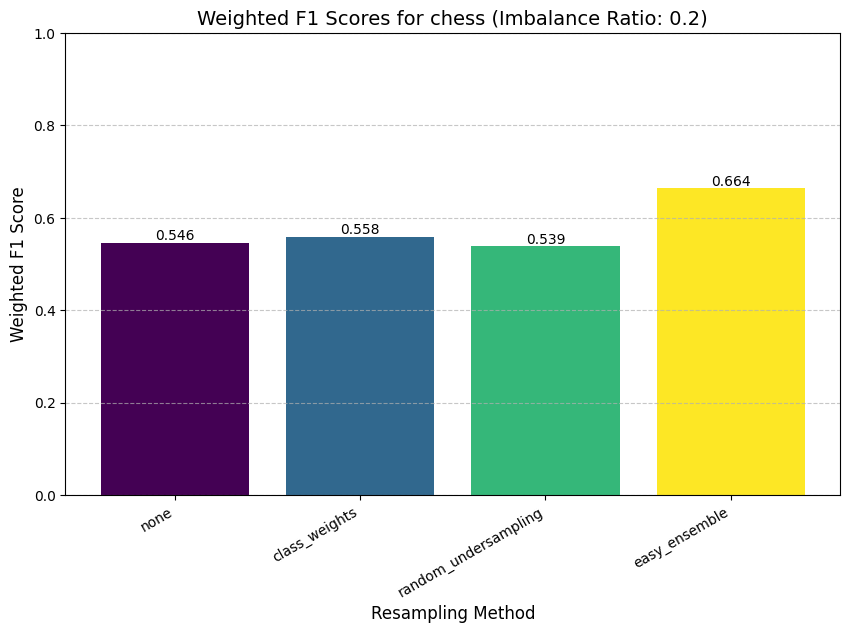

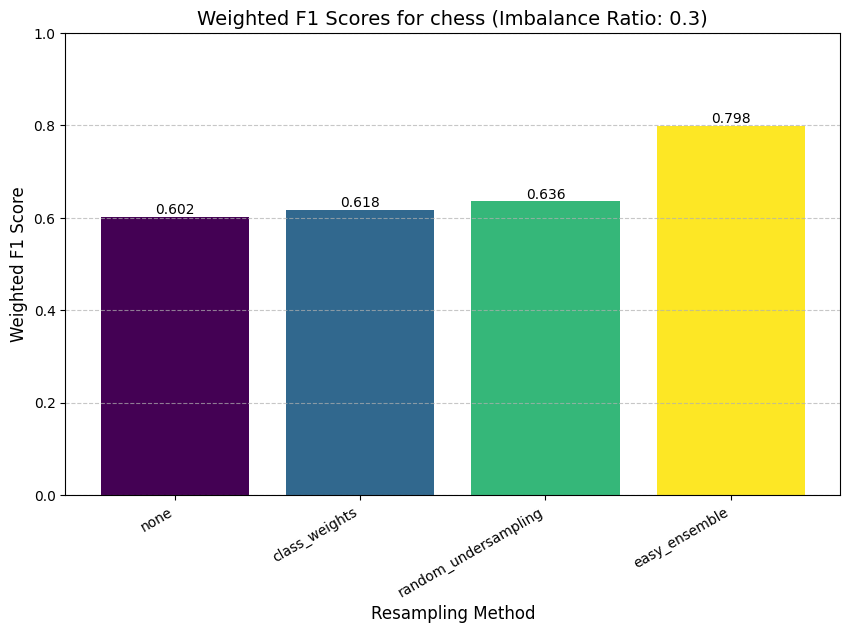

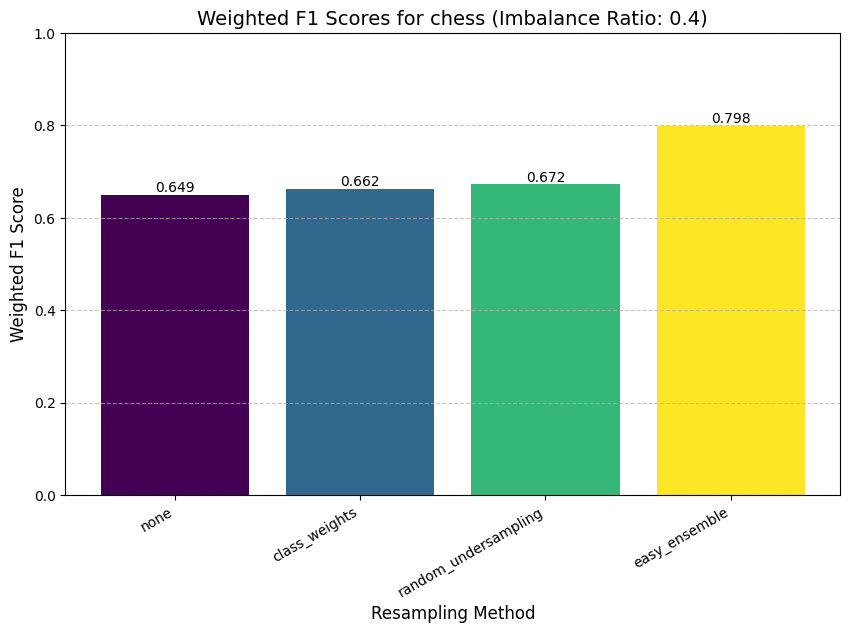

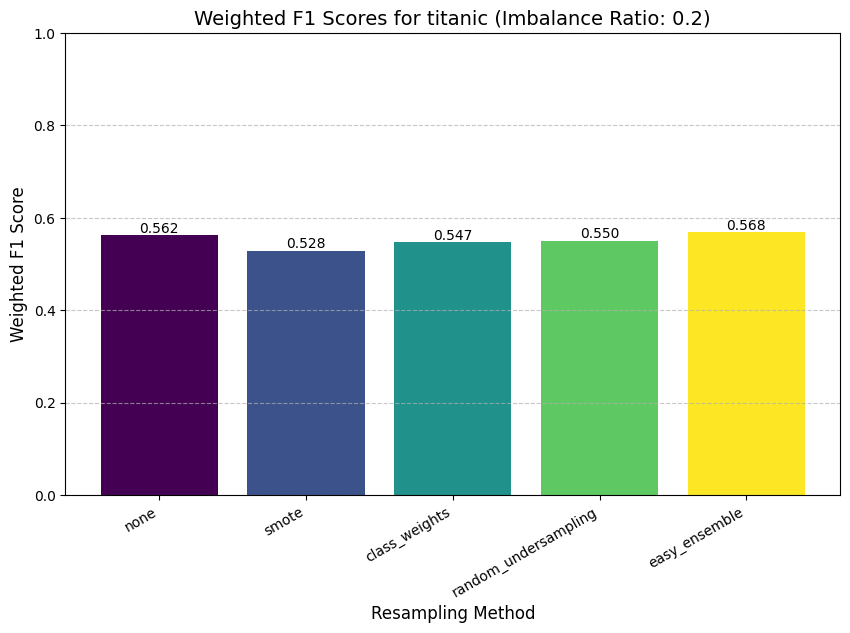

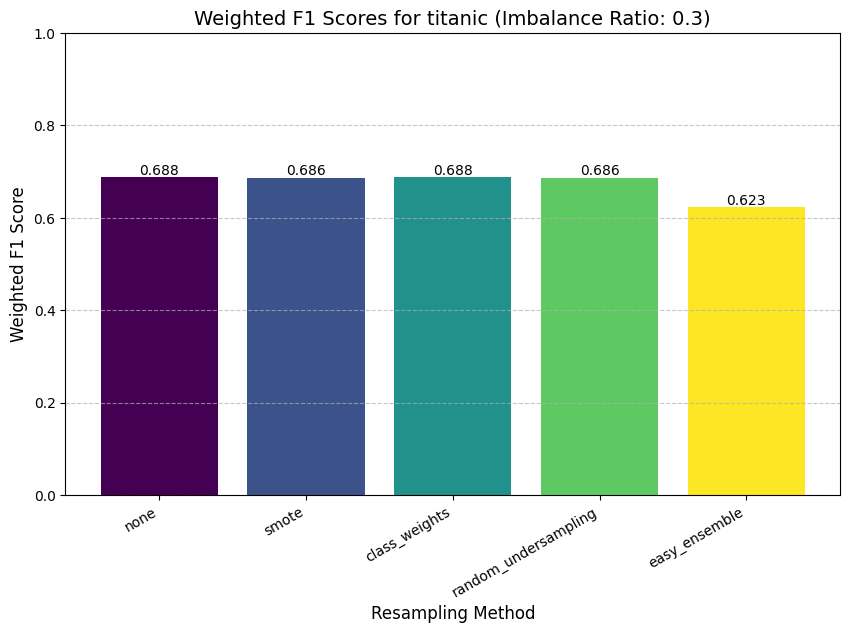

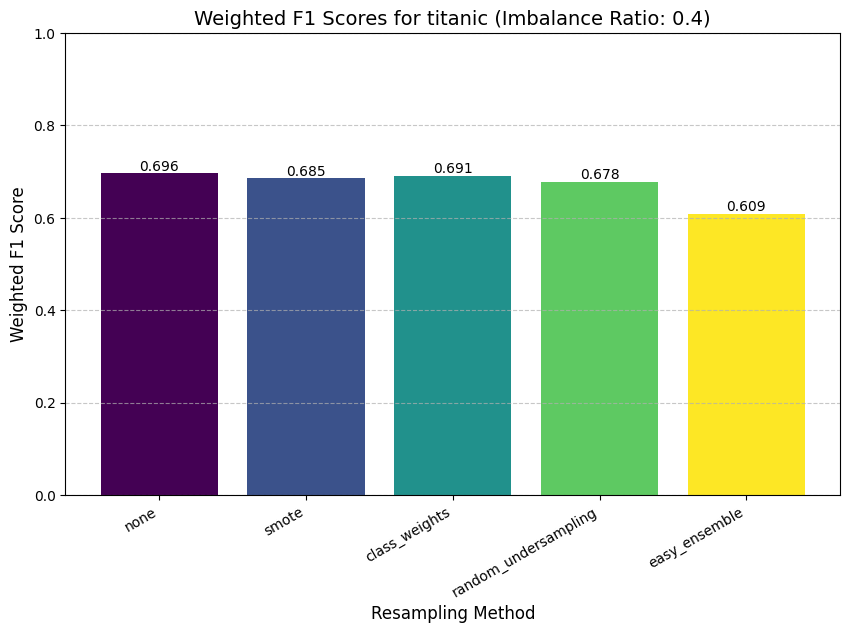

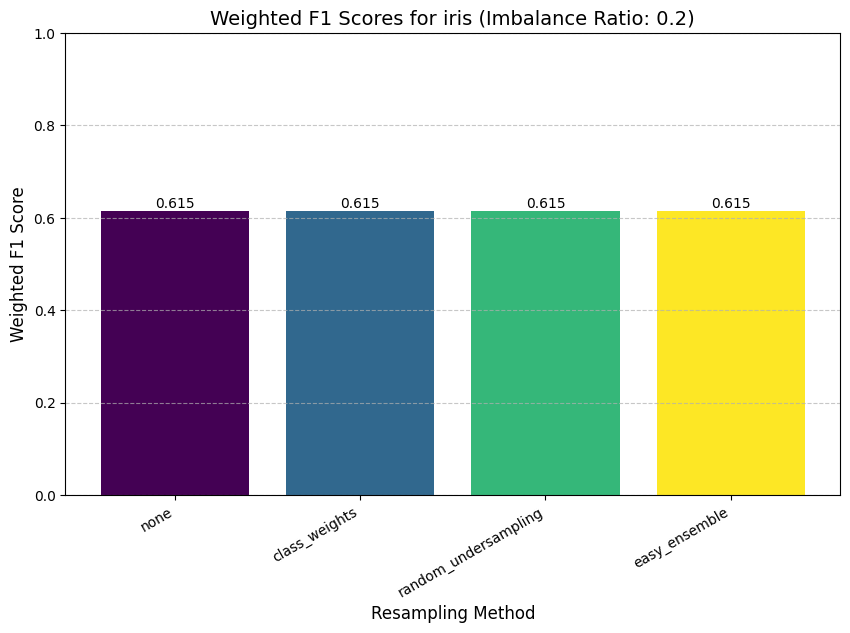

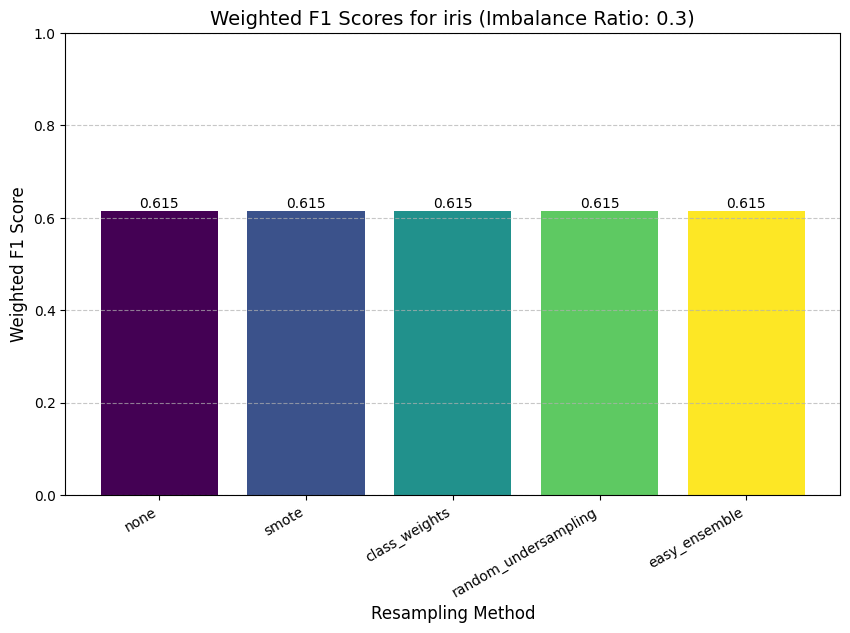

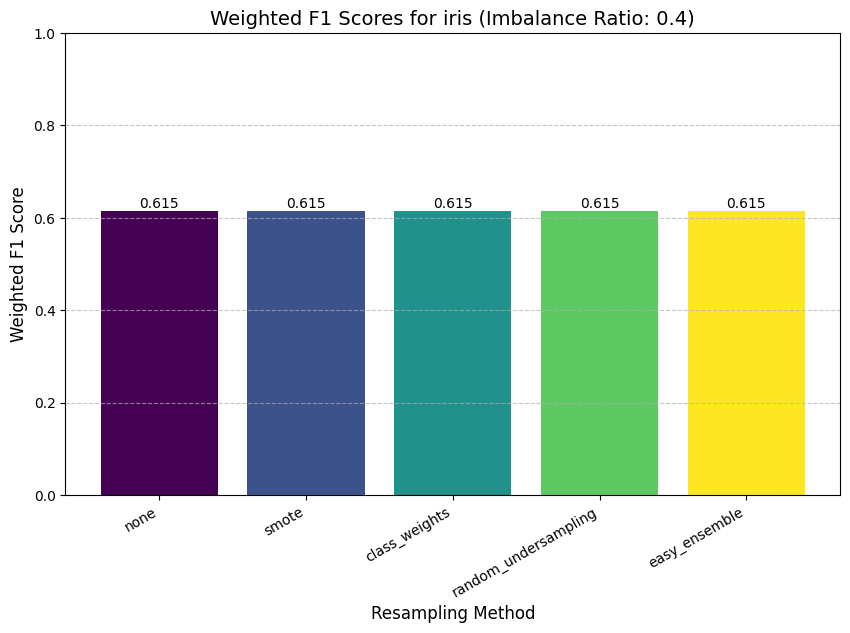

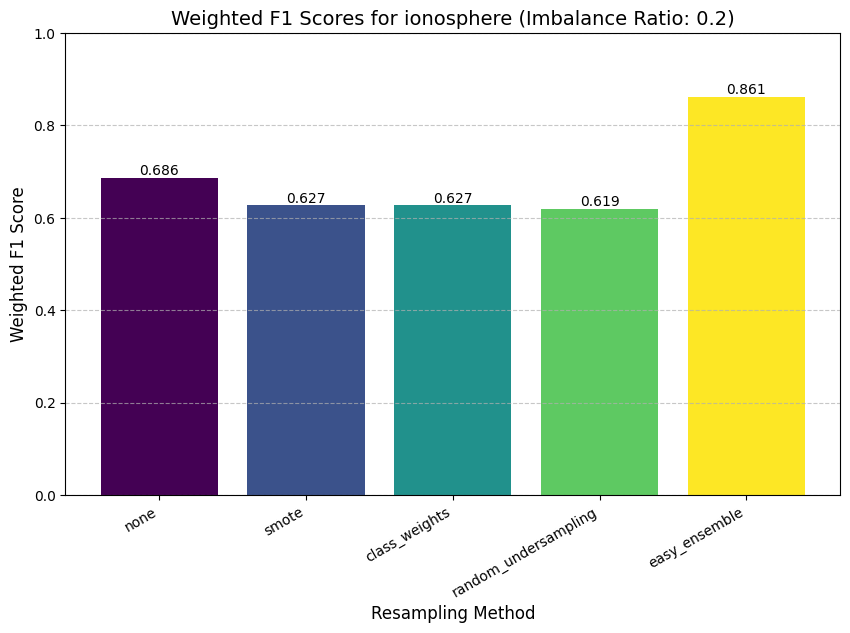

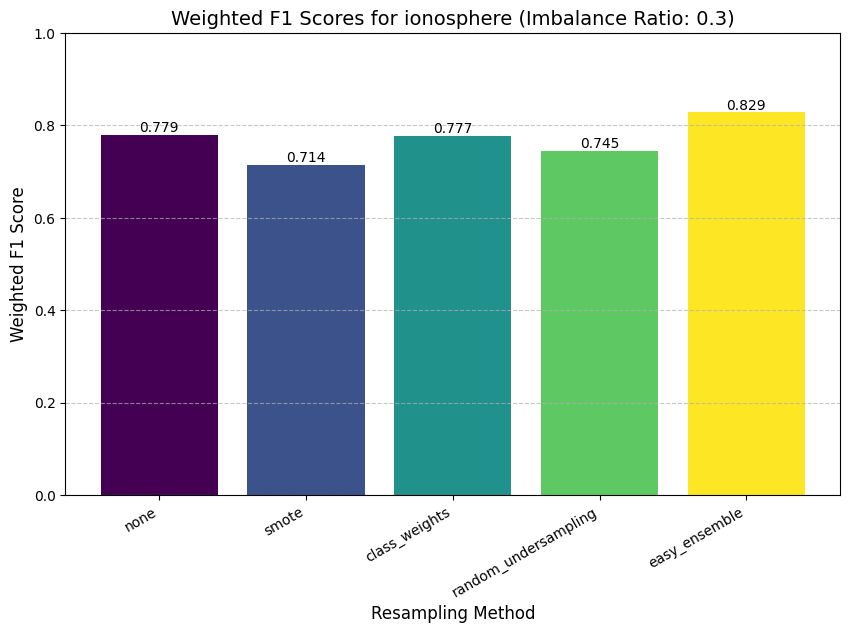

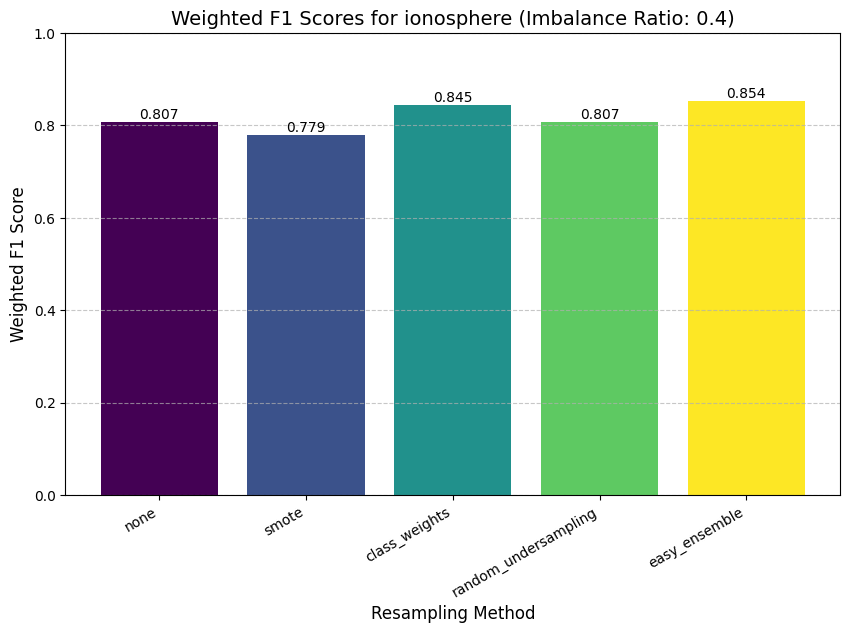

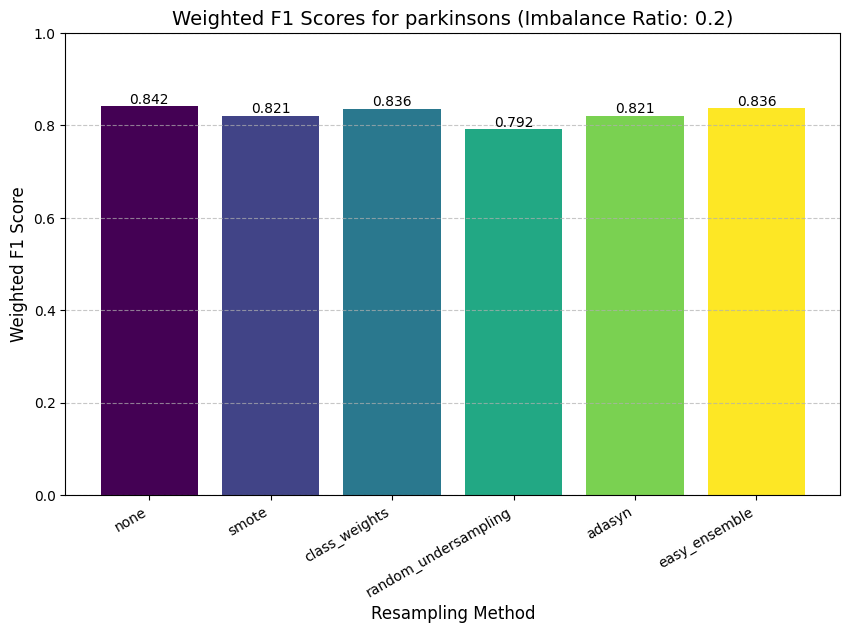

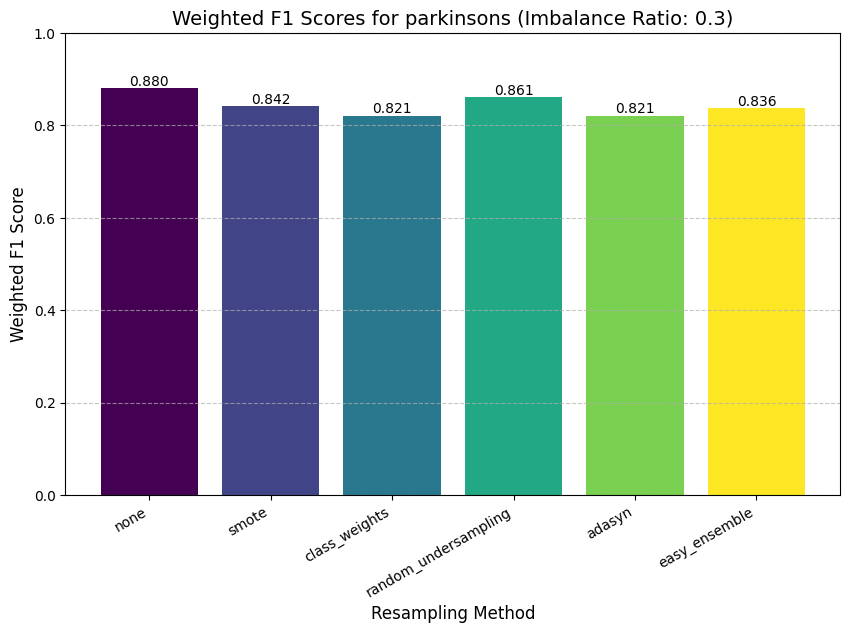

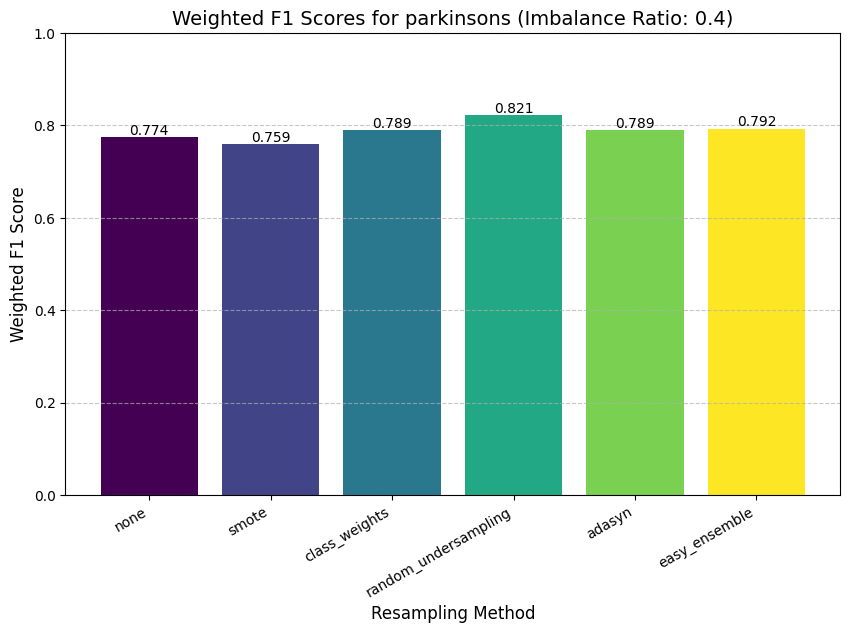

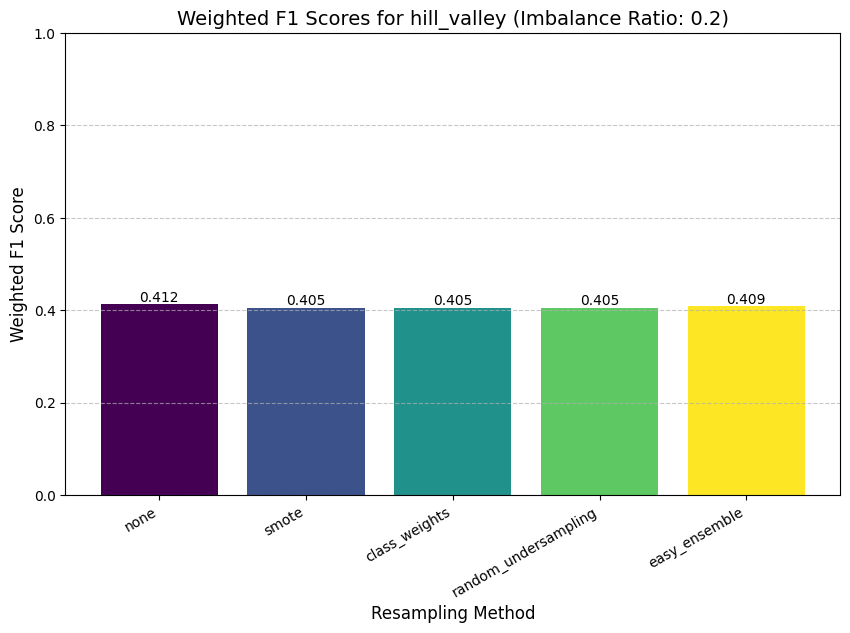

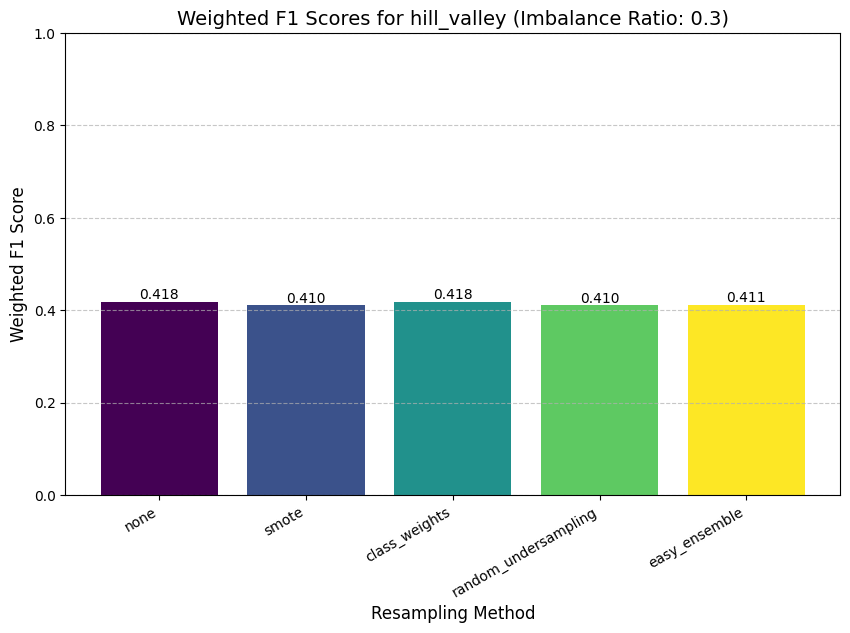

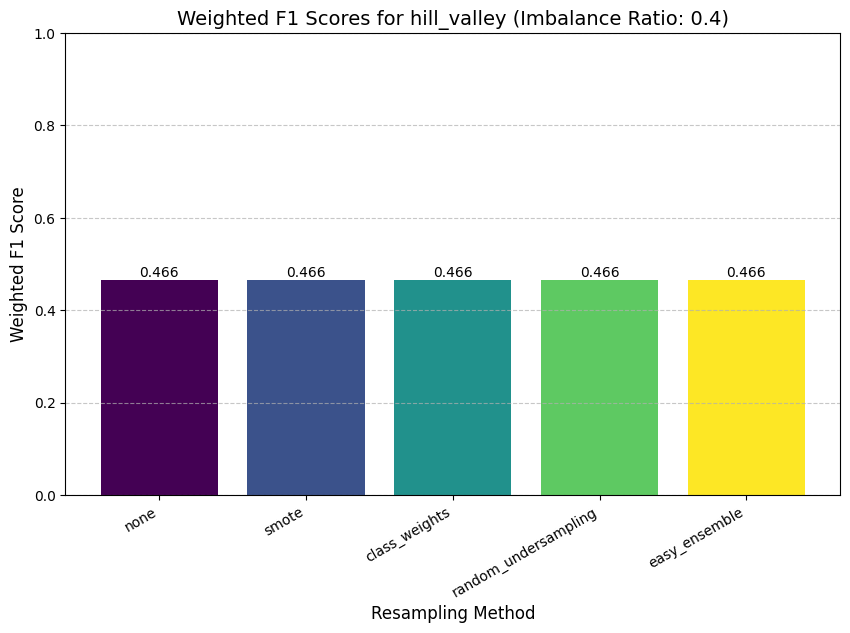

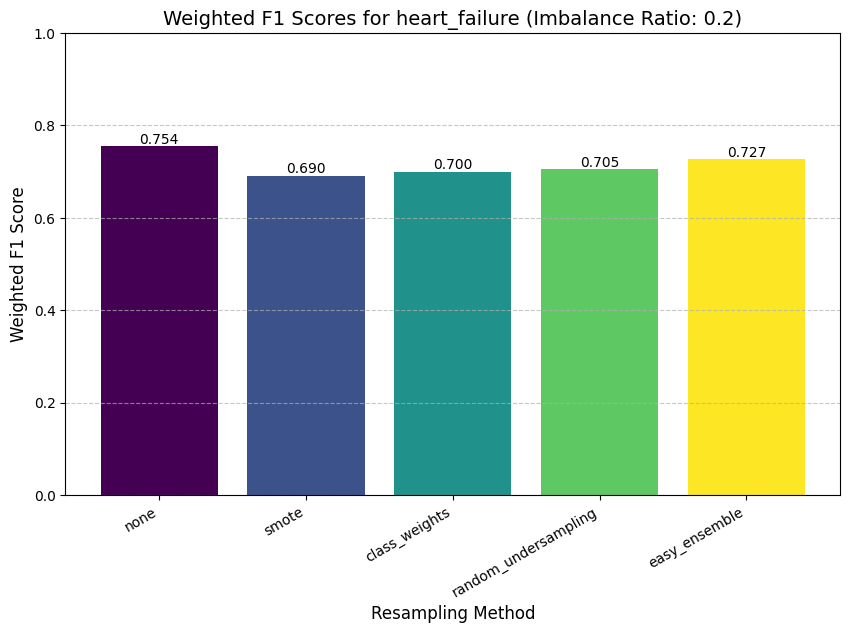

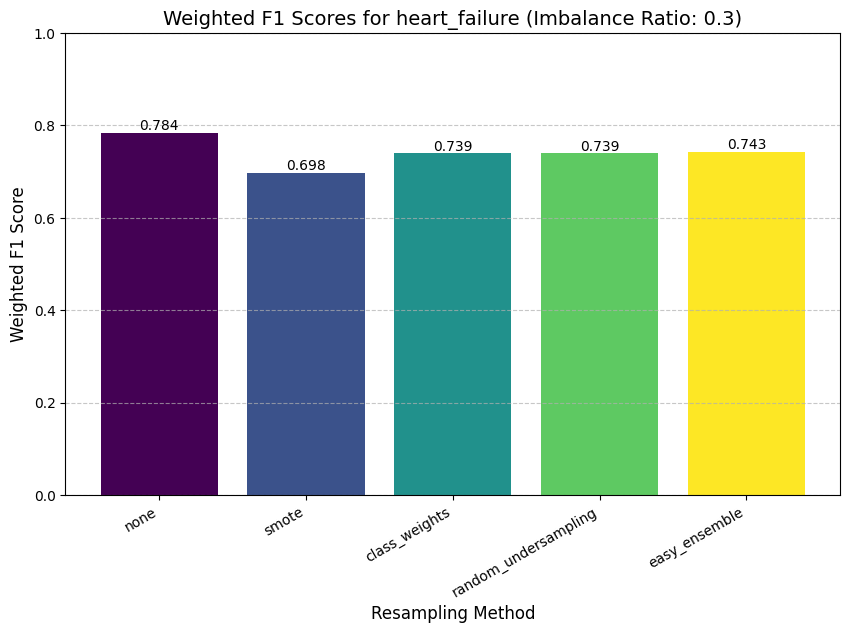

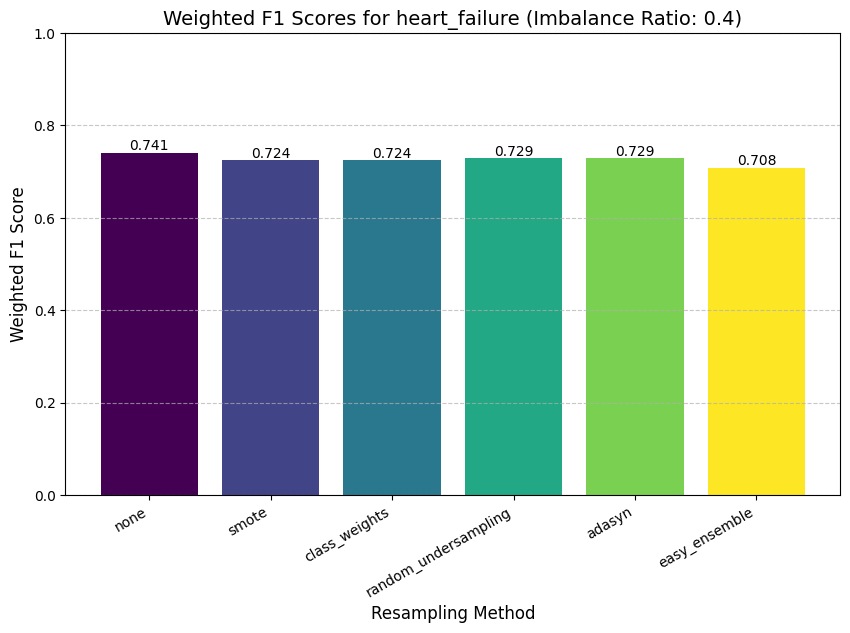

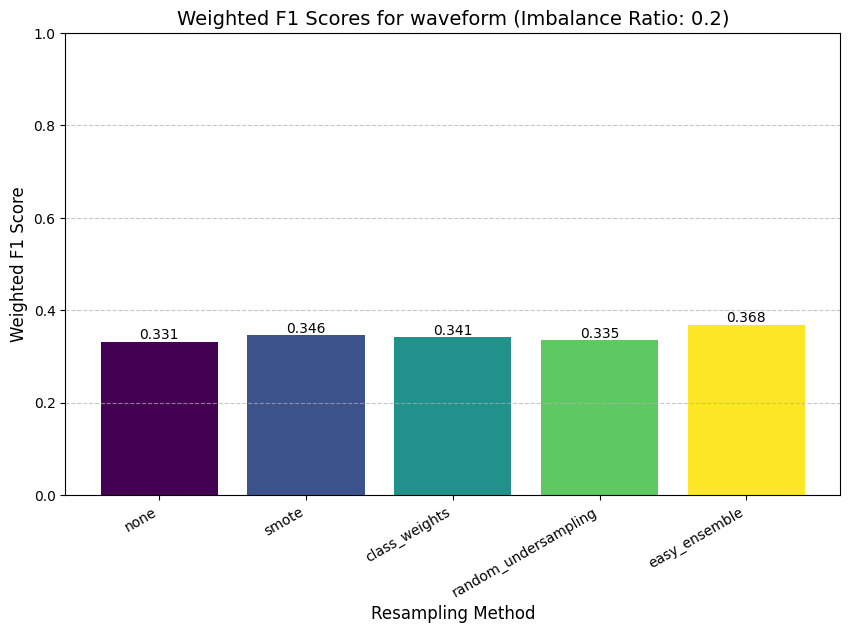

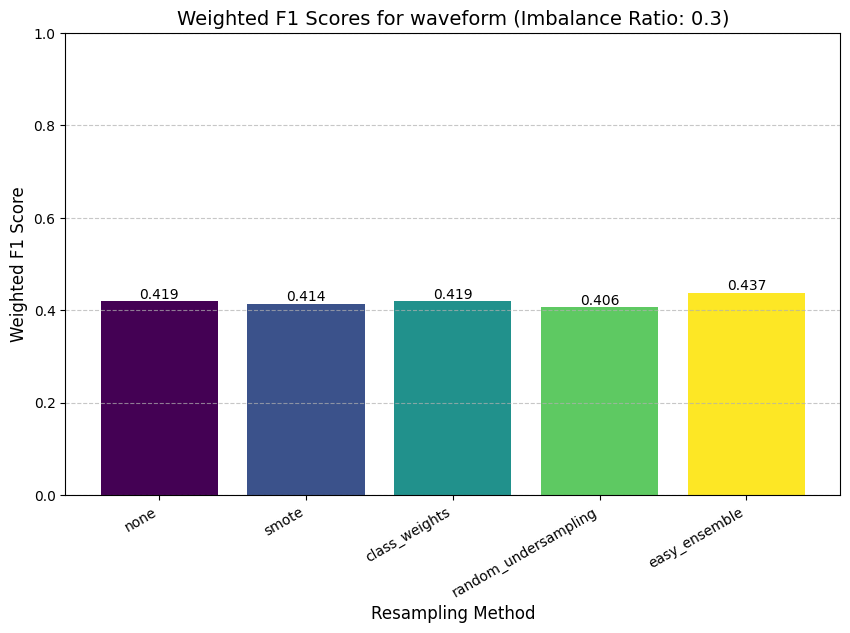

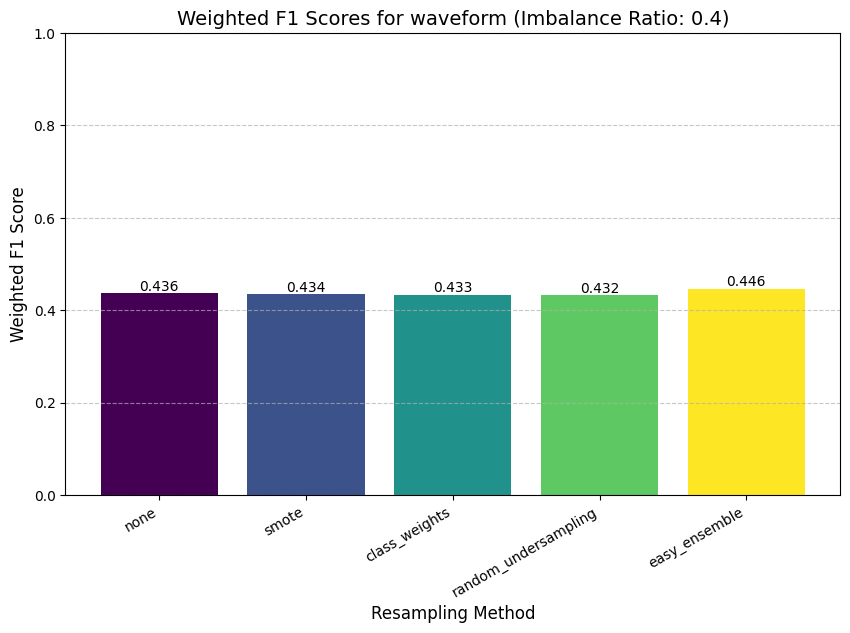

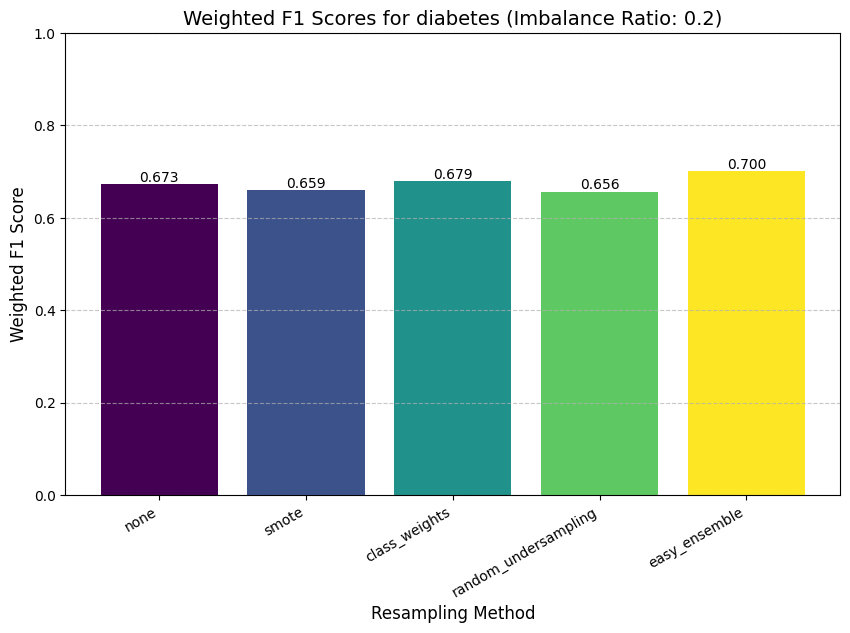

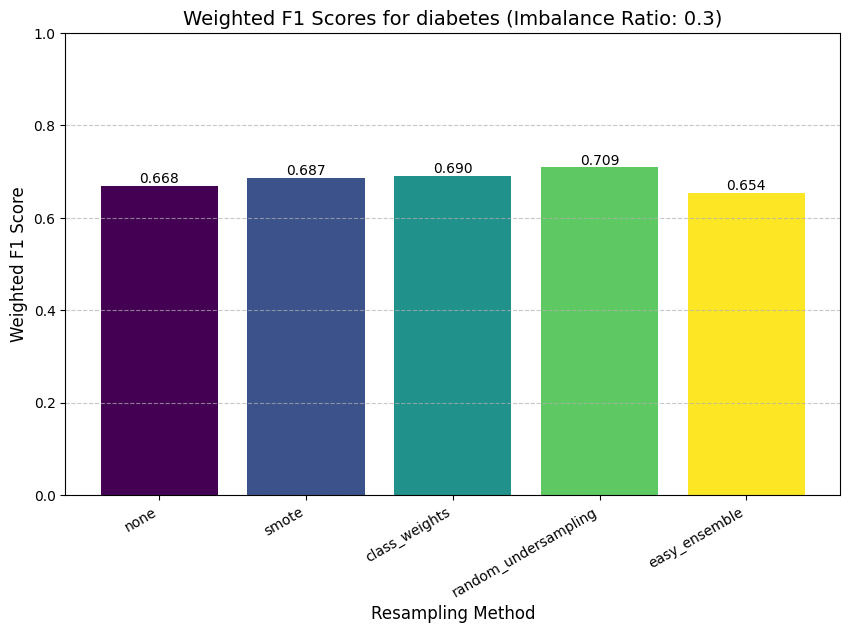

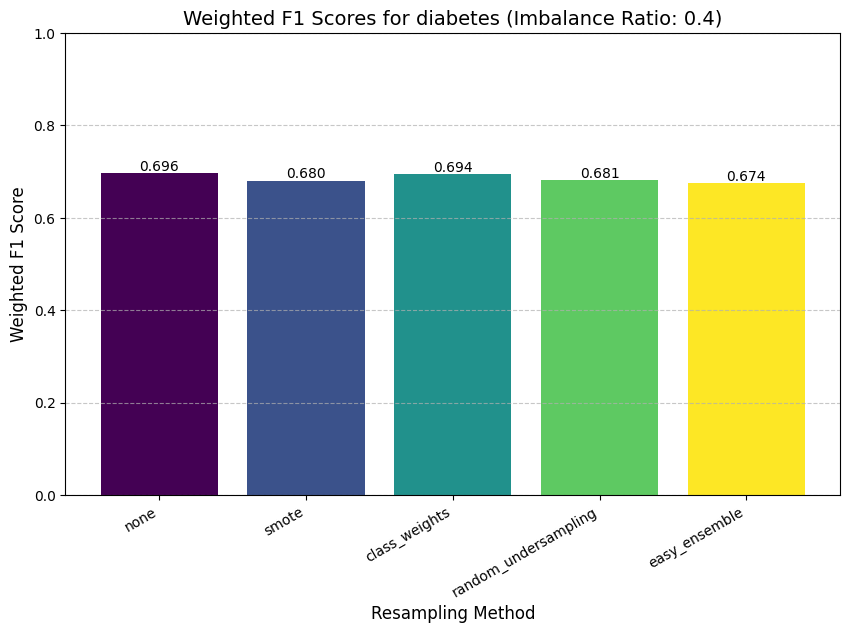

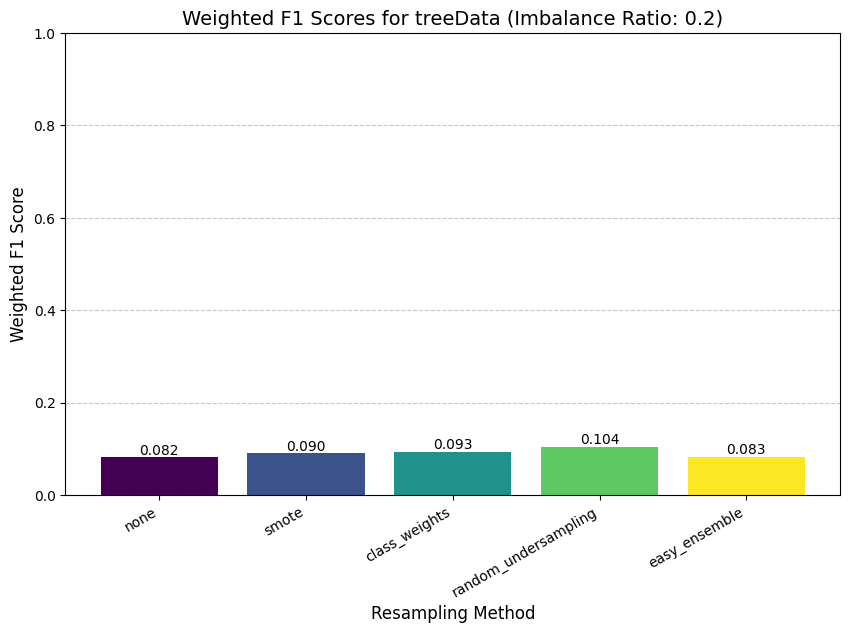

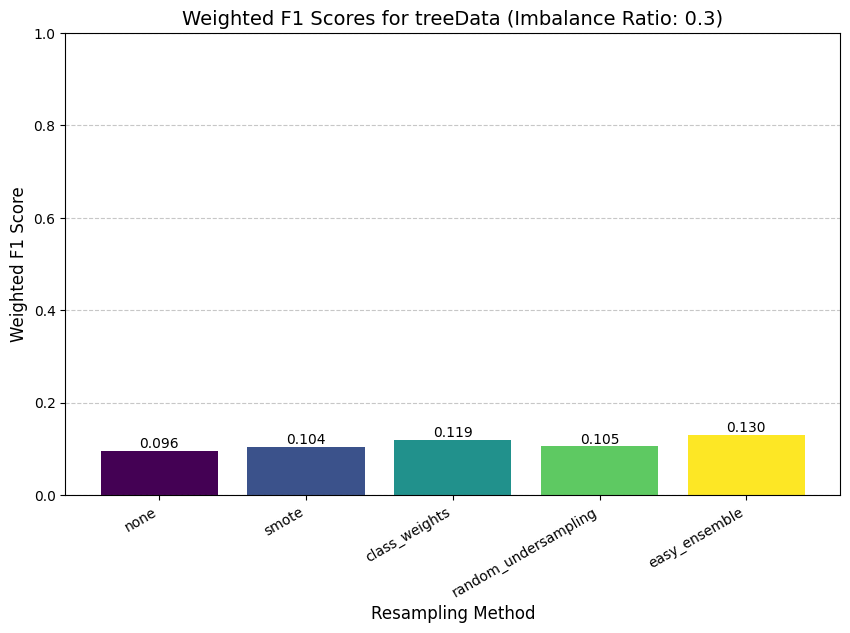

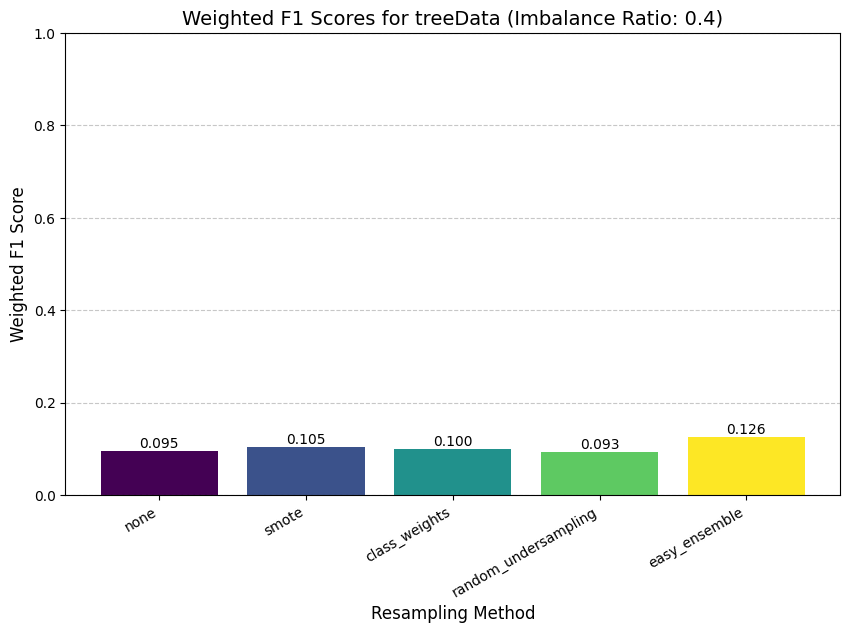

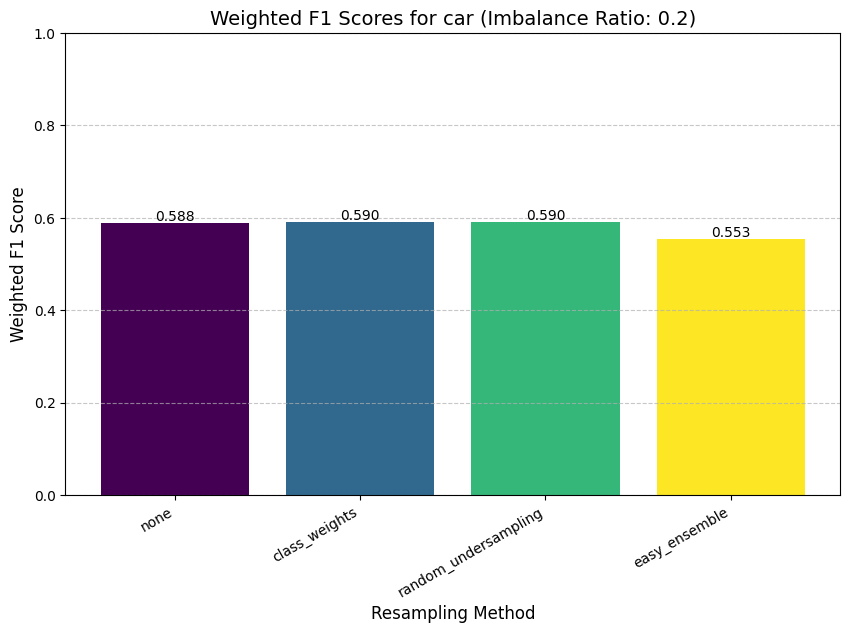

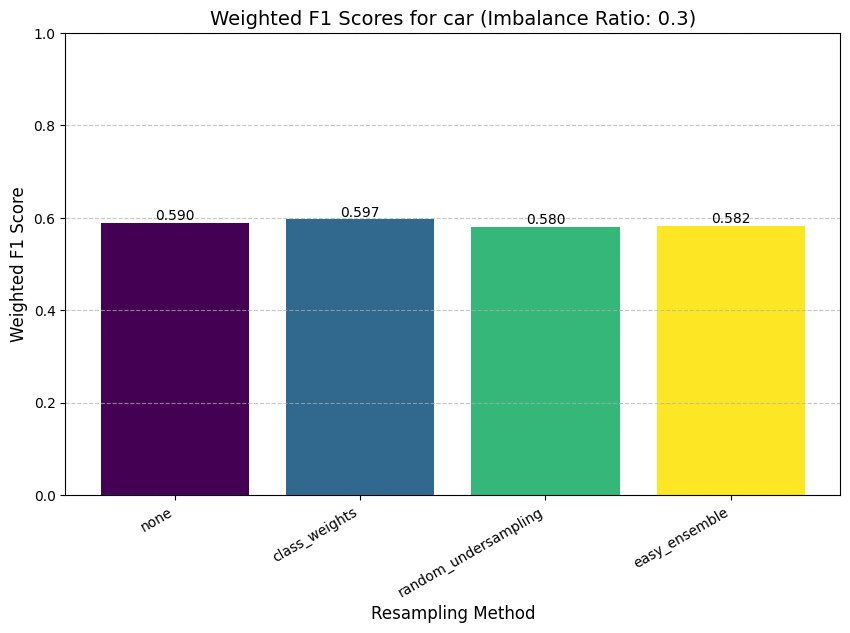

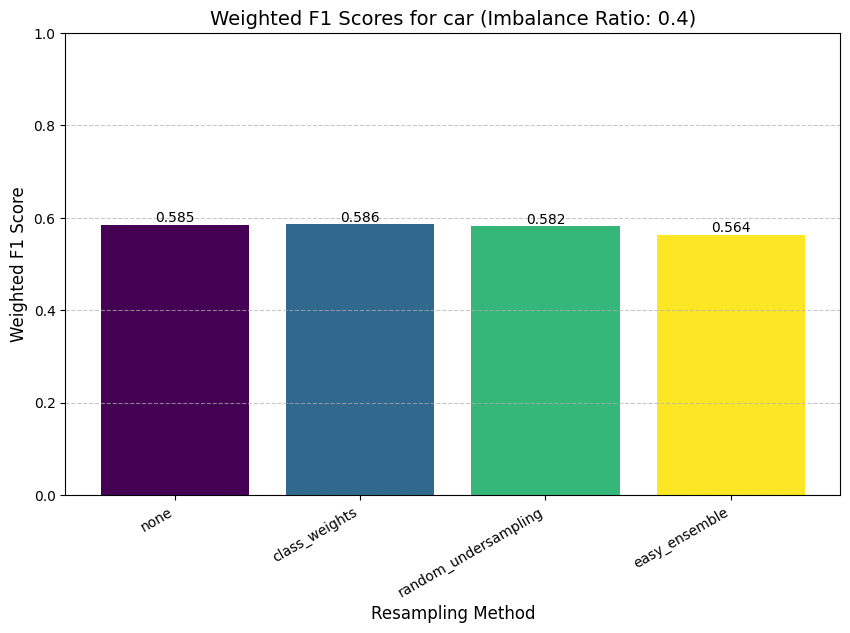

In [29]:
# Convert results to DataFrame, filtering out failed runs
valid_results = [res for res in results if "Weighted F1 Score" in res]  # ✅ Correct key name
results_df = pd.DataFrame(valid_results)

# Rename columns to maintain consistency
results_df.rename(columns={"Dataset": "dataset", 
                           "Method": "method", 
                           "Imbalance Ratio": "imbalance_ratio", 
                           "Weighted F1 Score": "f1_score"}, inplace=True)  # ✅ Correct renaming

# Ensure 'f1_score' is numeric (avoid KeyError)
results_df["f1_score"] = pd.to_numeric(results_df["f1_score"], errors="coerce")

# Improved function to visualize results
def plot_f1_scores(results_df):
    for dataset in results_df["dataset"].unique():
        df = results_df[results_df["dataset"] == dataset]
        
        for ratio in df["imbalance_ratio"].unique():
            subset = df[df["imbalance_ratio"] == ratio]
            
            # Create figure with larger size for clarity
            plt.figure(figsize=(10, 6))
            
            # Use consistent colormap
            colors = plt.cm.viridis(np.linspace(0, 1, len(subset)))
            
            # Bar chart
            bars = plt.bar(subset["method"], subset["f1_score"], color=colors)
            
            # Display F1 scores on top of bars
            for bar in bars:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                         f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10)
            
            # Titles & labels
            plt.title(f"Weighted F1 Scores for {dataset} (Imbalance Ratio: {ratio})", fontsize=14)
            plt.xlabel("Resampling Method", fontsize=12)
            plt.ylabel("Weighted F1 Score", fontsize=12)
            
            # Format x-axis
            plt.xticks(rotation=30, ha='right', fontsize=10)
            
            # Limit F1 Score range for better comparison
            plt.ylim(0, 1)  
            
            # Add grid for better readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Show plot
            plt.show()

# Call function to visualize results
plot_f1_scores(results_df)


In [115]:
class GenericMethodHandler:
    def __init__(self, dataset=None, target_column=None, test_size=0.3, imbalance_ratio=0.2, random_state=42):
        self.dataset = dataset
        self.target_column = target_column
        self.test_size = test_size
        self.imbalance_ratio = imbalance_ratio
        self.random_state = random_state
        self.original_x_train = None
        self.original_y_train = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

        if self.dataset is not None:
            self._prepare_data()

    def _prepare_data(self):
        if self.target_column not in self.dataset.columns:
            raise ValueError(f"Target column '{self.target_column}' not found in dataset.")

        x = self.dataset.drop(columns=[self.target_column])
        y = self.dataset[self.target_column]

        # Handle missing values
        num_cols = x.select_dtypes(include=["number"]).columns
        cat_cols = x.select_dtypes(include=["object", "category"]).columns
        x[num_cols] = x[num_cols].fillna(x[num_cols].median())  # Median for numeric data
        for col in cat_cols:
            x[col] = x[col].fillna(x[col].mode()[0])  # Mode for categorical data

        # Encode categorical features
        x = pd.get_dummies(x, drop_first=True)  
        x = x.apply(pd.to_numeric, errors='coerce')

        # Split into training and test sets
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=self.test_size, random_state=self.random_state
        )

        # Introduce imbalance only once and store it
        self.original_x_train, self.original_y_train = self._introduce_imbalance(x_train, y_train)
        self.x_train, self.y_train = self.original_x_train.copy(), self.original_y_train.copy()
        self.x_test, self.y_test = x_test, y_test

        # Store imbalanced dataset for future resets
        self.fixed_x_train = self.original_x_train.copy()
        self.fixed_y_train = self.original_y_train.copy()

    def _introduce_imbalance(self, x_train, y_train, total_per_group=20):
        """
        Introduces class imbalance using sequential resampling with user-defined groups.

        Args:
            x_train (pd.DataFrame): Training feature set.
            y_train (pd.Series): Training labels.
            total_per_group (int): The number of samples per iteration (default: 20).

        Returns:
            tuple: (x_train_new, y_train_new) with the introduced imbalance.
        """
        train_df = pd.concat([x_train, y_train], axis=1)

        # Identify class distributions
        class_counts = y_train.value_counts()
        total_samples = len(y_train)

        # Sort classes by size
        sorted_classes = class_counts.sort_values().index.tolist()
        smallest_class = sorted_classes[0]  # Class with least samples
        largest_class = sorted_classes[-1]  # Class with most samples

        # Get current proportions
        current_ratios = class_counts / total_samples

        # Target proportions based on imbalance ratio
        target_minority_ratio = self.imbalance_ratio
        target_majority_ratio = 1 - self.imbalance_ratio

        # Compute chunk sizes
        minority_per_group = max(1, int(total_per_group * target_minority_ratio))
        majority_per_group = max(1, total_per_group - minority_per_group)

        # Determine how many times we can run this process
        max_iterations = max(1, min(class_counts[smallest_class] // minority_per_group, 
                                    class_counts[largest_class] // majority_per_group))

        # If the minority proportion is too high → Undersample the majority
        final_samples = []
        for _ in range(max_iterations):
            minority_chunk = resample(
                train_df[train_df[y_train.name] == smallest_class],
                replace=False, n_samples=minority_per_group, random_state=self.random_state
            )
            majority_chunk = resample(
                train_df[train_df[y_train.name] == largest_class],
                replace=False, n_samples=majority_per_group, random_state=self.random_state
            )
            final_samples.append(pd.concat([minority_chunk, majority_chunk]))

        # Combine all sampled chunks
        imbalanced_train_df = pd.concat(final_samples).sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        return imbalanced_train_df.drop(columns=[y_train.name]), imbalanced_train_df[y_train.name]


    def reset_training_data(self):
        self.x_train, self.y_train = self.fixed_x_train.copy(), self.fixed_y_train.copy()

    def apply_smote(self, sampling_strategy="auto"):
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=self.random_state)
        self.x_train, self.y_train = smote.fit_resample(self.x_train, self.y_train)

    def apply_adasyn(self, sampling_strategy="auto"):
        adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=self.random_state)
        self.x_train, self.y_train = adasyn.fit_resample(self.x_train, self.y_train)

    def apply_random_undersampling(self, sampling_strategy="auto"):
        rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=self.random_state)
        self.x_train, self.y_train = rus.fit_resample(self.x_train, self.y_train)

    def train_and_evaluate_generalized(self, method, max_depth=None, n_estimators=10):
        self.reset_training_data()

        if method == "none":
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "class_weights":
            model = RandomForestClassifier(
                max_depth=max_depth, class_weight="balanced", random_state=self.random_state
            )
        elif method == "smote":
            self.apply_smote()
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "adasyn":
            self.apply_adasyn()
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "random_undersampling":
            self.apply_random_undersampling()
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)
        elif method == "easy_ensemble":
            model = EasyEnsembleClassifier(n_estimators=n_estimators, random_state=self.random_state)
        else:
            raise ValueError("Invalid Method")

        model.fit(self.x_train, self.y_train)
        predictions = model.predict(self.x_test)

        return {
            "accuracy": accuracy_score(self.y_test, predictions),
            "f1_score": f1_score(self.y_test, predictions, average="weighted"),
            "confusion_matrix": confusion_matrix(self.y_test, predictions),
            "classification_report": classification_report(self.y_test, predictions, output_dict=True),
        }

    def run_multiple_configs(self, datasets, methods, imbalance_ratios):
        results = Parallel(n_jobs=-1)(
            delayed(self._run_single_config)(name, dataset, method, ratio)
            for name, dataset in datasets.items()
            for method in methods
            for ratio in imbalance_ratios
        )
        print(f"Completed processing {len(results)} configurations.")
        return results

    def _run_single_config(self, dataset_name, dataset, method, imbalance_ratio):
        try:
            self.dataset = dataset
            self.target_column = self.target_column or dataset.columns[0]
            self.imbalance_ratio = imbalance_ratio
            self._prepare_data()
            result = self.train_and_evaluate_generalized(method=method)
            return {"dataset": dataset_name, "method": method, "imbalance_ratio": imbalance_ratio, **result}
        except Exception as e:
            return {"dataset": dataset_name, "method": method, "imbalance_ratio": imbalance_ratio, "error": str(e)}

In [ ]:
# Extract a single dataset
just_one = {"sonar": datasets_dict["sonar"]}

handler = GenericMethodHandler()

results = handler.run_multiple_configs(
    datasets=just_one,
    methods=["none", "smote", "class_weights", "adasyn", "random_undersampling", "easy_ensemble"],
    imbalance_ratios=[0.15]
)

results


Completed processing 6 configurations.


[{'dataset': 'sonar',
  'method': 'none',
  'imbalance_ratio': 0.15,
  'accuracy': 0.6031746031746031,
  'f1_score': 0.4953782305225429,
  'confusion_matrix': array([[35,  0],
         [25,  3]], dtype=int64),
  'classification_report': {'M': {'precision': 0.5833333333333334,
    'recall': 1.0,
    'f1-score': 0.7368421052631579,
    'support': 35.0},
   'R': {'precision': 1.0,
    'recall': 0.10714285714285714,
    'f1-score': 0.19354838709677416,
    'support': 28.0},
   'accuracy': 0.6031746031746031,
   'macro avg': {'precision': 0.7916666666666667,
    'recall': 0.5535714285714286,
    'f1-score': 0.465195246179966,
    'support': 63.0},
   'weighted avg': {'precision': 0.7685185185185186,
    'recall': 0.6031746031746031,
    'f1-score': 0.4953782305225429,
    'support': 63.0}}},
 {'dataset': 'sonar',
  'method': 'smote',
  'imbalance_ratio': 0.15,
  'accuracy': 0.6031746031746031,
  'f1_score': 0.4953782305225429,
  'confusion_matrix': array([[35,  0],
         [25,  3]], dtype

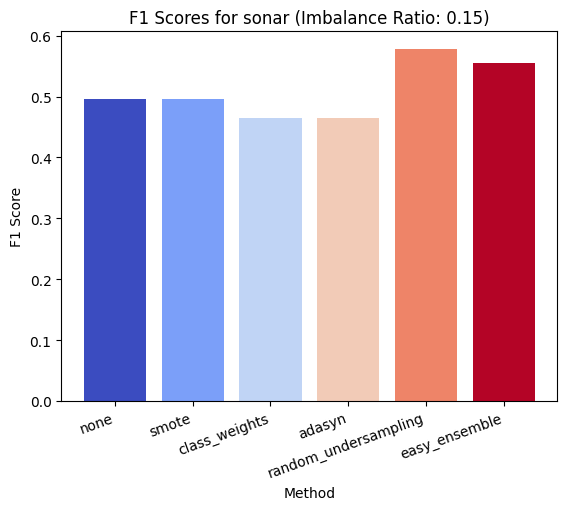

In [119]:
results_df = pd.DataFrame(results)

# Plot F1 scores for each dataset and imbalance ratio
def plot_f1_scores(results_df):
    for dataset in results_df["dataset"].unique():
        df = results_df[results_df["dataset"] == dataset]
        for ratio in df["imbalance_ratio"].unique():
            subset = df[df["imbalance_ratio"] == ratio]
            plt.figure()
            colors = plt.cm.coolwarm(np.linspace(0, 1, len(subset)))
            plt.bar(subset["method"], subset["f1_score"], color=colors)
            plt.title(f"F1 Scores for {dataset} (Imbalance Ratio: {ratio})")
            plt.xlabel("Method")
            plt.ylabel("F1 Score")
            plt.xticks(rotation=20, ha='right')
            plt.show()

plot_f1_scores(results_df)

